In [1053]:
#Essentials
import pandas as pd
import numpy as np

#Plots
import seaborn as sns
import matplotlib.pyplot as plt


#Models
from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble
import xgboost
import lightgbm
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from mlxtend.regressor import StackingCVRegressor


#Misc
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn import neighbors
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

#ignore warnings
import warnings
warnings.filterwarnings("ignore")


# path='C:\\Users\\sunsharp\\Desktop\\kaggle\\house-pricing\\'
path=r'/Users/ranmo/Desktop/kaggle/house-pricing/'



In [1054]:
#===========
# 函数定义
#===========

#1、训练模型
def model_eval(model,X_train,y_train):
    l_rmes=[]
    kf=model_selection.KFold(10,random_state=10)
    for train,test in kf.split(X_train):
        X_train1 = X_train.iloc[train]
        y_train1 = y_train.iloc[train]
        X_test1 = X_train.iloc[test]
        y_test1 = y_train.iloc[test]

        y_pred1=model.fit(X_train1,y_train1).predict(X_test1)
        e=np.sqrt(metrics.mean_squared_error(y_pred1,y_test1))   #还要再转化为root值
        l_rmes.append(e)
    print(l_rmes)
    print(np.mean(l_rmes))
    print()
    print()
    return np.mean(l_rmes)

#2、模型预测
def model_predict(model,X_test,outpath):
    y_test_pred=model.predict(X_test)
    SalePrice_pred=np.floor(np.exp(y_test_pred))
    df_reg=pd.DataFrame({'Id':X_test.index,'SalePrice':SalePrice_pred}).set_index('Id')
    df_reg.to_csv('%stest_pred.csv'%outpath)

In [4]:
#看一下特征情况
df=pd.read_csv('%strain.csv'%path)
df=df.set_index('Id')
df['SalePrice']=np.log(df['SalePrice'])  #直接在原数据进行处理了，方便之后的分析
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [5]:
#看一下有无负值
df.describe().min() #无负值数据

MSSubClass         20.000000
LotFrontage        21.000000
LotArea          1300.000000
OverallQual         1.000000
OverallCond         1.000000
YearBuilt          30.202904
YearRemodAdd       20.645407
MasVnrArea          0.000000
BsmtFinSF1          0.000000
BsmtFinSF2          0.000000
BsmtUnfSF           0.000000
TotalBsmtSF         0.000000
1stFlrSF          334.000000
2ndFlrSF            0.000000
LowQualFinSF        0.000000
GrLivArea         334.000000
BsmtFullBath        0.000000
BsmtHalfBath        0.000000
FullBath            0.000000
HalfBath            0.000000
BedroomAbvGr        0.000000
KitchenAbvGr        0.000000
TotRmsAbvGrd        1.625393
Fireplaces          0.000000
GarageYrBlt        24.689725
GarageCars          0.000000
GarageArea          0.000000
WoodDeckSF          0.000000
OpenPorchSF         0.000000
EnclosedPorch       0.000000
3SsnPorch           0.000000
ScreenPorch         0.000000
PoolArea            0.000000
MiscVal             0.000000
MoSold        

In [6]:
#看一下非数值类的数据，需要进行独热编码
df.dtypes[df.dtypes==object]
df1=pd.get_dummies(df)
df.shape
df1.shape     #由原始的81个特征扩展为289个特征

(1460, 289)

In [7]:
#检查缺失项,独热编码会把缺失项全编码为0，因此是不用考虑的
# 可以通过这样的方式来直接判断
# df[df.dtypes[df.dtypes!=object].index].info()
# 不好直接判断，也可以通过这样来判断
for i in df1.columns:
    if df1[i].value_counts().sum()!=len(df1):
        print(i)
#查看一下缺失项的具体详情：
# LotFrontage：Linear feet of street connected to property  物业到街道的距离
# MasVnrArea：Masonry veneer area in square feet     砌面贴面面积
# GarageYrBlt：Year garage was built   车库建成的日期

#处理缺失值
df1['LotFrontage']=df1['LotFrontage'].fillna(df['LotFrontage'].mean())
df1['MasVnrArea']=df1['MasVnrArea'].fillna(0)
df1['GarageYrBlt']=df1['GarageYrBlt'].fillna(df['GarageYrBlt'].mean())

LotFrontage
MasVnrArea
GarageYrBlt


In [8]:
#数据处理完，用xgboost跑一下基本模型
X_train=df1.sample(frac=1,random_state=10).drop('SalePrice',axis=1)
y_train=df1.sample(frac=1,random_state=10).SalePrice  

In [10]:
#=============
#xgboost 跑一下基本模型
#=============
reg=xgboost.XGBRegressor(objective='reg:squarederror')

model_eval(reg,X_train,y_train)

[0.14745709735269863, 0.10545197238798604, 0.13752780560423744, 0.10297579608968334, 0.13263136614076368, 0.10877189061273217, 0.12231945139267782, 0.18830864920575893, 0.12382892427475191, 0.1251114329288676]
0.12943843859901577




0.12943843859901577

In [13]:
#=============
#用基本模型测试一下
#=============

df_test=pd.read_csv('%stest.csv'%path).set_index('Id')
#独热编码,这个必须联合train里的数据进行编码了，不然维度是不够的
temp=pd.concat([df,df_test],axis=0)
temp=temp[df.columns]   #columns被打乱，重新排一下
temp=pd.get_dummies(temp)
df1_test=temp.loc[df_test.index.to_list()]

#缺失值处理
for i in df1_test.columns:
    if df1_test[i].value_counts().sum()!=len(df1_test):
        print(i)
#缺失值有点多,有比较多0值的都处理为0
df1_test['LotFrontage']=df1_test['LotFrontage'].fillna(df['LotFrontage'].mean())
df1_test['MasVnrArea']=df1_test['MasVnrArea'].fillna(0)
df1_test['BsmtFinSF1']=df1_test['BsmtFinSF1'].fillna(0)
df1_test['BsmtFinSF2']=df1_test['BsmtFinSF2'].fillna(0)
df1_test['BsmtUnfSF']=df1_test['BsmtUnfSF'].fillna(0)
df1_test['TotalBsmtSF']=df1_test['TotalBsmtSF'].fillna(0)
df1_test['BsmtFullBath']=df1_test['BsmtFullBath'].fillna(0)
df1_test['BsmtHalfBath']=df1_test['BsmtHalfBath'].fillna(0)
df1_test['GarageYrBlt']=df1_test['GarageYrBlt'].fillna(df['GarageYrBlt'].mean())
df1_test['GarageCars']=df1_test['GarageCars'].fillna(0)
df1_test['GarageArea']=df1_test['GarageArea'].fillna(0)

#用训练好的模型预测
X_test=df1_test.drop('SalePrice',axis=1)

if X_test.shape[1]==X_train.shape[1]:
    print('ok')
    
    
# #模型预测
# outpath='%s//reg//1211//'%path
# reg.fit(X_train,y_train)
# model_predict(reg,X_test,outpath)  

LotFrontage
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
BsmtFullBath
BsmtHalfBath
GarageYrBlt
GarageCars
GarageArea
SalePrice
ok


In [12]:
X_test.shape

(1459, 288)

- 成绩13.971

一、EDA

偏度：0.121335
峰度：0.809532


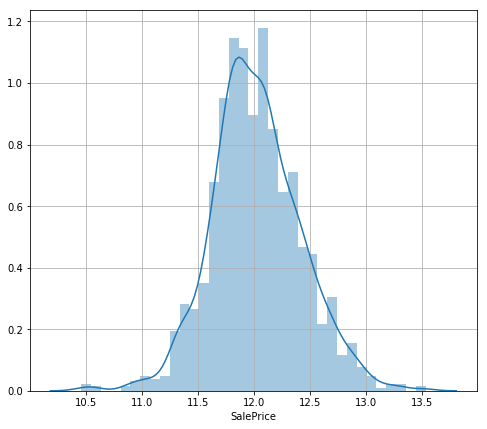

In [64]:
#重新进行EDA探索

#销售价格分布
plt.figure(figsize=(8,7))
sns.distplot(df.SalePrice)
plt.grid(True)

print('偏度：%f'%df.SalePrice.skew())       #标准正太分布为0
print('峰度：%f'%df.SalePrice.kurt())       #标准正太分布为1

# 对原始数据去了对数之后，正好分布趋于正态分布

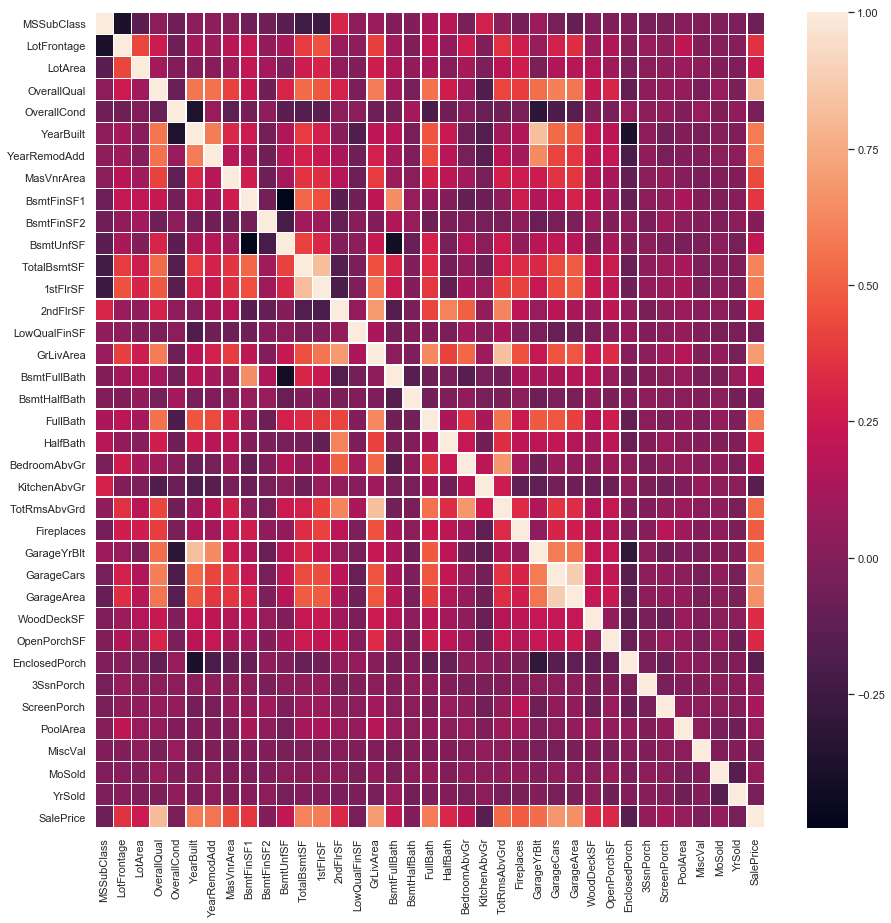

In [91]:
#数据相关性
corrmat=df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corrmat,linewidths=0.5)

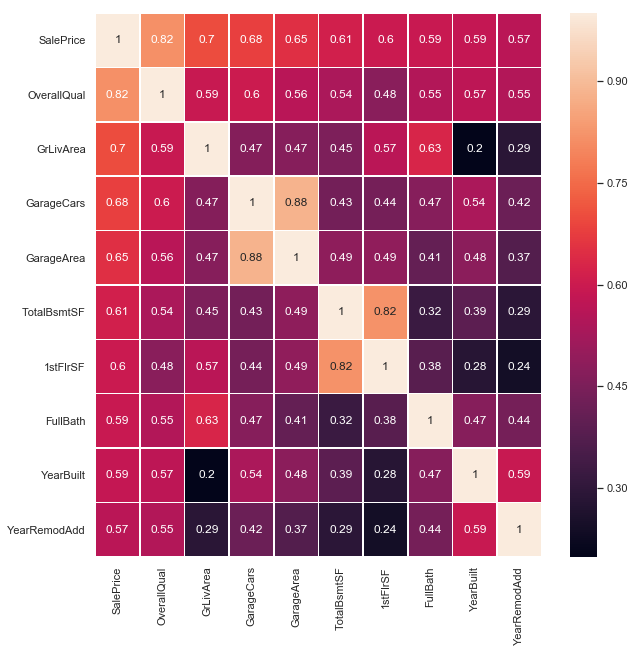

In [92]:
#选取相关性最高的10个特征
corrmat_new=df[corrmat.nlargest(10,'SalePrice')['SalePrice'].index].corr()

plt.figure(figsize=(10,10))
sns.heatmap(corrmat_new,linewidths=0.5,annot=True)

- OverallQual，GrLivArea  与 SalePrice 有很强的相关性。
- GarageCars 和 GarageArea 两者的相关性也较高，实际上有车还会有车库，两者就是强相关变量，可以去除一个变量，去掉了GarageArea。
- TotalBsmtSF 和 1stFloor也是互为强相关变量，可以去除一个变量，去掉了1stFloor。
- TotRmsAbvGrd 和 GrLivArea也是互为强相关变量，可以去除一个变量，去掉了TotRmsAbvGrd。
- FullBath、TotRmsAbvGrd、YearBuilt和SalePrice的相关性一般。

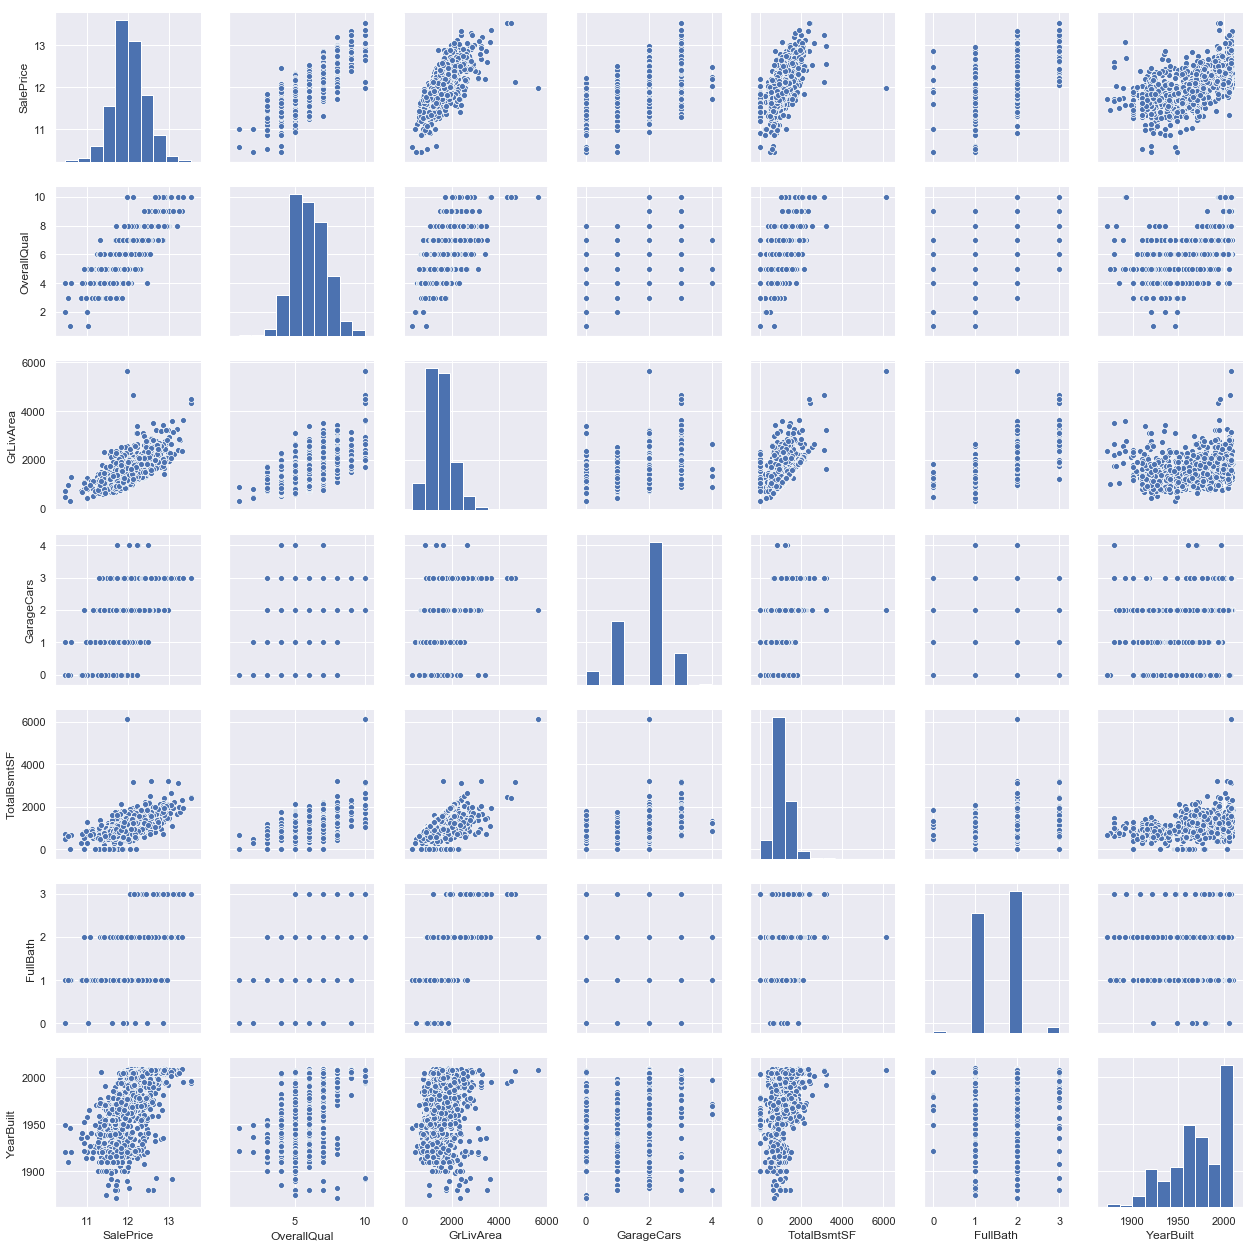

In [68]:
sns.set()
sns.pairplot(df[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']])
#这里是只保留了部分特征，去掉了GarageArea、1stFloor、TotRmsAbvGrd



- 从上面的对图可以看出是存在离群点（异常点的），所以有必要把离群点筛选出来

In [14]:
#检测异常点,这个只是单纯靠样本分布的间隔来检测

def detect_outliers(x,k=5,plot=False,y=df.SalePrice,n=40):
    x_new=x.dropna()  #必须把空值去了
    lof=neighbors.LocalOutlierFactor(n_neighbors=n)
    lof.fit_predict(np.array(x_new).reshape(-1,1))
    lof_scr = lof.negative_outlier_factor_
    out_idx=x_new.index[pd.Series(lof_scr).sort_values()[:k].index]         #因为去了空值之后index不对应了，所以要转化
    if plot:
        plt.figure(figsize=(10,8))
        plt.scatter(x_new,y[x_new.index],c=np.exp(lof_scr), cmap='RdBu') #用指数是为了放大差距
    return out_idx

- 附局部密度离群点检测：https://blog.csdn.net/wangyibo0201/article/details/51705966

n=10:   [1341, 977, 1248, 395, 813]
n=15:   [1341, 1253, 977, 147, 288]
n=20:   [1341, 1253, 147, 977, 771]
n=25:   [1299, 524, 1183, 534, 692]
n=30:   [1299, 524, 1183, 534, 692]
n=35:   [1299, 524, 1183, 692, 534]
n=40:   [1299, 524, 1183, 692, 534]
n=45:   [1299, 524, 1183, 692, 534]
n=50:   [1299, 524, 1183, 692, 534]
n=55:   [1299, 524, 1183, 534, 692]
n=60:   [1299, 524, 1183, 534, 692]
n=65:   [1299, 524, 534, 1183, 692]


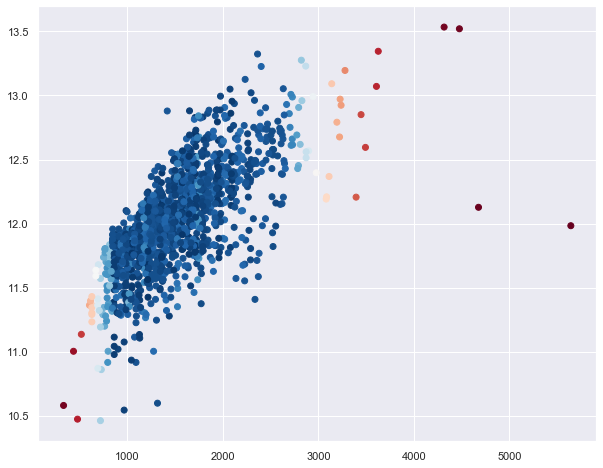

In [117]:
# 以GrLivArea为例进行检测
#sns.set()
outs=detect_outliers(df.GrLivArea,plot=True)
#实际上 lof 离群检测中n的设置会影响结果，看一下n的合适取值
for i in range(10,70,5):
    outs=detect_outliers(df.GrLivArea,n=i)
    print('n=%d:   %s'%(i, list(outs)))

- 所以默认的n=40的话应该是一个比较合适的值，这时候的lof 离群值趋于稳定

In [12]:
#对所有数据维度进行lof 离群点检测，并判断其离群的次数

from collections import Counter
all_outliers=[]
numeric_features = df.drop('SalePrice',axis=1).dtypes[df.drop('SalePrice',axis=1).dtypes != 'object'].index

for i in numeric_features:
    outs=detect_outliers(df[i])   #存在nan值情况
    all_outliers.extend(outs)
print(Counter(all_outliers).most_common())

[(1299, 4), (1271, 3), (376, 3), (534, 3), (524, 3), (636, 3), (635, 3), (1, 3), (977, 3), (976, 3), (979, 3), (978, 3), (314, 2), (336, 2), (1214, 2), (1167, 2), (813, 2), (78, 2), (8, 2), (954, 2), (497, 2), (1183, 2), (955, 2), (598, 2), (1164, 2), (1351, 2), (1329, 2), (165, 1), (874, 1), (590, 1), (556, 1), (125, 1), (708, 1), (1370, 1), (1307, 1), (816, 1), (250, 1), (707, 1), (452, 1), (637, 1), (917, 1), (1101, 1), (305, 1), (509, 1), (219, 1), (1443, 1), (1059, 1), (241, 1), (592, 1), (278, 1), (772, 1), (1141, 1), (1224, 1), (1024, 1), (1362, 1), (983, 1), (380, 1), (386, 1), (700, 1), (220, 1), (230, 1), (791, 1), (931, 1), (1029, 1), (696, 1), (646, 1), (1150, 1), (126, 1), (600, 1), (575, 1), (333, 1), (441, 1), (1025, 1), (1374, 1), (432, 1), (1401, 1), (186, 1), (171, 1), (1010, 1), (89, 1), (692, 1), (739, 1), (189, 1), (327, 1), (625, 1), (299, 1), (1284, 1), (54, 1), (190, 1), (810, 1), (49, 1), (204, 1), (435, 1), (1219, 1), (643, 1), (167, 1), (310, 1), (606, 1), (1

In [223]:
#一共检测出140个离群点，理论上出现次数越多的点，为离群点的概率就越大，这里用模型精度来检验


l_rems_list=[]
print('outlier_number=0:')
l_rems_list.append(model_eval(reg,X_train,y_train))

i=5
while i<=140:
    outliers_list=Counter(all_outliers).most_common()[:i]
    outliers_listid=pd.DataFrame(outliers_list,columns=['Id','times']).Id
    #开始模型精度测试
    print('outlier_number=%d:'%(i))
    l_rems=model_eval(reg,X_train.drop(index=outliers_listid),y_train.drop(index=outliers_listid))
    l_rems_list.append(l_rems)
    i+=5



outlier_number=0:
[0.14057352394649075, 0.10434470268150993, 0.10436370804899309, 0.1255864082182403, 0.12635218704043835, 0.1433328445004293, 0.12860730237131596, 0.10804294060379642, 0.12986508568514202, 0.18078213711369587]
0.1291850840210052


outlier_number=5:
[0.11620273522682971, 0.15042194308836745, 0.09466096199470914, 0.1354201566045275, 0.14018721796079614, 0.11136932105981052, 0.11766394199363374, 0.1164881497674969, 0.12521022823737496, 0.12429608153964947]
0.12319207374731955


outlier_number=10:
[0.12334802089306812, 0.12221307017631108, 0.11760250300445672, 0.0972210025004671, 0.11742637947570728, 0.11527517953017925, 0.1521118668873459, 0.1416309694569849, 0.14121575266207834, 0.11818191007011418]
0.12462266546567129


outlier_number=15:
[0.09143009969394734, 0.13928102927952848, 0.12120942906649866, 0.11039836065206206, 0.12191566549654868, 0.10108071873620067, 0.14178509249475837, 0.15714873759467474, 0.10791187264095967, 0.13254545127406347]
0.12247064569292423


ou

Text(0.5, 0, 'outliers_number')

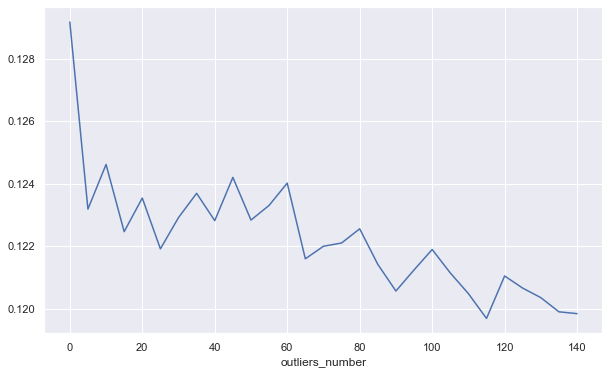

In [224]:
plt.figure(figsize=(10,6))
plt.plot(range(0,141,5),l_rems_list,)
plt.xlabel('outliers_number')

- 从模型精度来看，原数据中缺失存在很多异常点，而且随着筛选出来的异常点越来越多，整体的精度还有进一步下降的空间。所以这里通过调整k值来看一下筛选多少异常点合适。
- 但是不排除模型精度的提升是因为样本量的减少，而这些样本本身是正常的，只是部分维度无法用模型很好的预测，因此剔除了这部分数据后，导致模型精度上升，但实际上是模型欠拟合。

k=0,outlier_number=0:
[0.10871937901869588, 0.14546514337895863, 0.10702269161655545, 0.13367394968467775, 0.14121553943117127, 0.12325224796517315, 0.13552485891186497, 0.13906176764799402, 0.15709839080807994, 0.099895146669574]
0.12909291151327448


k=4,outlier_number=114:
[0.12184321449586044, 0.09118976450883896, 0.11931558159090119, 0.11197162037505251, 0.10372173387435486, 0.11082201799442135, 0.12351409736347177, 0.16702182434339924, 0.13154191117797806, 0.10731476924194233]
0.11882565349662208


k=5,outlier_number=140:
[0.11843931024680275, 0.13061543167245926, 0.10873840507569088, 0.10823782208262255, 0.10801573539842914, 0.12372833788308592, 0.13944468006334887, 0.10968689944763059, 0.10357540559010765, 0.12453476346729042]
0.11750167909274681


k=6,outlier_number=160:
[0.1053410550834751, 0.13645690254394796, 0.10835360075991614, 0.10876209365556028, 0.10323988306736823, 0.12083877993127054, 0.1108823677062826, 0.1592532652642992, 0.11305730747281499, 0.10857836768150676]
0

Text(0.5, 0, 'k_number')

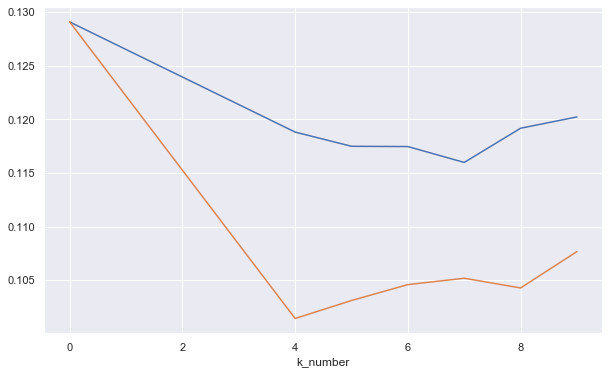

In [247]:
#粗筛异常点
from collections import Counter
numeric_features = df.drop('SalePrice',axis=1).dtypes[df.drop('SalePrice',axis=1).dtypes != 'object'].index
outliers_number=[]
l_rems_list1=[]   #用剔除异常后的数据训练模型并自行测试
l_rems_list2=[]   #用剔除异常后的数据训练模型并测试全部数据

print('k=0,outlier_number=0:')
l_rems=model_eval(reg,X_train,y_train)
l_rems_list1.append(l_rems)
l_rems_list2.append(l_rems)


for k in range(4,10,1):
    all_outliers=[]
    for i in numeric_features:
        outs=detect_outliers(df[i],k=k)  
        all_outliers.extend(outs)
        outliers_number.append(len(Counter(all_outliers).most_common()))

    #将其全部剔除后进行模型测试
    outliers_listid=pd.DataFrame(Counter(all_outliers).most_common(),columns=['Id','times']).Id
    #开始模型精度测试
    print('k=%d,outlier_number=%d:'%(k,len(Counter(all_outliers).most_common())))
    l_rems1=model_eval(reg,X_train.drop(index=outliers_listid),y_train.drop(index=outliers_listid))  
    l_rems_list1.append(l_rems1)
    l_rems2=np.sqrt(metrics.mean_squared_error(reg.fit(X_train.drop(index=outliers_listid),y_train.drop(index=outliers_listid)).predict(X_train),y_train))  
    l_rems_list2.append(l_rems2)

# plt
plt.figure(figsize=(10,6))
plt.plot([0,4,5,6,7,8,9],l_rems_list1)
plt.plot([0,4,5,6,7,8,9],l_rems_list2)
plt.xlabel('k_number')

- k=4~7之间可能是合适的值，而具体是采用模型自评的结果，还是模型测试全部数据的结果，两者是需要综合考虑的。（甚至需要观察数据集中是否存在类似的异常点，如果存在的话，则应更多地考虑全部数据的结果，不存在的话应该更多地考虑自评的结果，但这涉及到数据泄露。）
- 选取k=4做进一步的优化，是为了避免剔除太多的数据，避免把很多正常数据认为是异常。

In [ ]:
#粗筛异常点
from collections import Counter
numeric_features = df.drop('SalePrice',axis=1).dtypes[df.drop('SalePrice',axis=1).dtypes != 'object'].index
outliers_number=[]
l_rems_list1=[]   #用剔除异常后的数据训练模型并自行测试
l_rems_list2=[]   #用剔除异常后的数据训练模型并测试全部数据

print('k=0,outlier_number=0:')
l_rems=model_eval(reg,X_train,y_train)
l_rems_list1.append(l_rems)
l_rems_list2.append(l_rems)


for k in range(4,10,1):
    all_outliers=[]
    for i in numeric_features:
        outs=detect_outliers(df[i],k=k)  
        all_outliers.extend(outs)
        outliers_number.append(len(Counter(all_outliers).most_common()))

    #将其全部剔除后进行模型测试
    outliers_listid=pd.DataFrame(Counter(all_outliers).most_common(),columns=['Id','times']).Id
    #开始模型精度测试
    print('k=%d,outlier_number=%d:'%(k,len(Counter(all_outliers).most_common())))
    l_rems1=model_eval(reg,X_train.drop(index=outliers_listid),y_train.drop(index=outliers_listid))  
    l_rems_list1.append(l_rems1)
    l_rems2=np.sqrt(metrics.mean_squared_error(reg.fit(X_train.drop(index=outliers_listid),y_train.drop(index=outliers_listid)).predict(X_train),y_train))  
    l_rems_list2.append(l_rems2)

# plt
plt.figure(figsize=(10,6))
plt.plot([0,4,5,6,7,8,9],l_rems_list1)
plt.plot([0,4,5,6,7,8,9],l_rems_list2)
plt.xlabel('k_number')

[(1299, 16), (1271, 12), (524, 12), (636, 12), (635, 12), (1, 12), (977, 12), (979, 12), (314, 8), (336, 8), (376, 8), (534, 8), (1214, 8), (1167, 8), (497, 8), (1183, 8), (955, 8), (598, 8), (1164, 8), (1351, 8), (978, 8), (165, 4), (874, 4), (590, 4), (125, 4), (708, 4), (1370, 4), (1307, 4), (250, 4), (707, 4), (637, 4), (917, 4), (305, 4), (509, 4), (1443, 4), (1059, 4), (241, 4), (278, 4), (772, 4), (1141, 4), (1224, 4), (1024, 4), (1362, 4), (983, 4), (380, 4), (700, 4), (220, 4), (230, 4), (791, 4), (78, 4), (1029, 4), (696, 4), (646, 4), (1150, 4), (126, 4), (600, 4), (575, 4), (333, 4), (1025, 4), (432, 4), (1401, 4), (186, 4), (171, 4), (1010, 4), (692, 4), (739, 4), (189, 4), (625, 4), (299, 4), (54, 4), (810, 4), (49, 4), (204, 4), (435, 4), (643, 4), (167, 4), (310, 4), (1229, 4), (806, 4), (1159, 4), (1191, 4), (748, 4), (421, 4), (543, 4), (1373, 4), (517, 4), (352, 4), (500, 4), (64, 4), (1398, 4), (132, 4), (156, 4), (10, 4), (298, 4), (1329, 4), (1060, 4), (342, 4), (

Text(0.5, 0, 'outlier_number')

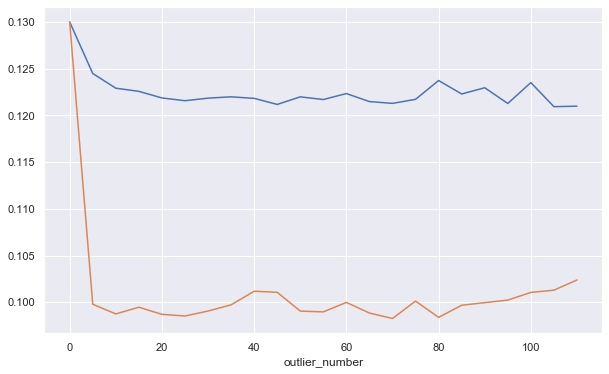

In [253]:
#精筛异常点，k=4时，共有114个异常点
for i in numeric_features:
    outs=detect_outliers(df[i],k=4)   #存在nan值情况
    all_outliers.extend(outs)
print(Counter(all_outliers).most_common())


l_rems_list1=[]   #用剔除异常后的数据训练模型并自行测试
l_rems_list2=[]   #用剔除异常后的数据训练模型并测试全部数据

print('outlier_number=0:')
l_rems=model_eval(reg,X_train,y_train)
l_rems_list1.append(l_rems)
l_rems_list2.append(l_rems)


i=5
while i<=114:
    outliers_list=Counter(all_outliers).most_common()[:i]
    outliers_listid=pd.DataFrame(outliers_list,columns=['Id','times']).Id
    #开始模型精度测试
    print('outlier_number=%d:'%(i))
    l_rems1=model_eval(reg,X_train.drop(index=outliers_listid),y_train.drop(index=outliers_listid))  
    l_rems_list1.append(l_rems1)
    l_rems2=np.sqrt(metrics.mean_squared_error(reg.fit(X_train.drop(index=outliers_listid),y_train.drop(index=outliers_listid)).predict(X_train),y_train))  
    l_rems_list2.append(l_rems2)
    i+=5

    
# plt
plt.figure(figsize=(10,6))
plt.plot(range(0,114,5),l_rems_list1)
plt.plot(range(0,114,5),l_rems_list2)
plt.xlabel('outlier_number')


- 可以肯定的是前5个点肯定是异常点，但从从模型训练结果来看，选择剔除20个异常点

In [16]:
# 剔除20个异常点

# from collections import Counter
# all_outliers=[]
# numeric_features = df.drop('SalePrice',axis=1).dtypes[df.drop('SalePrice',axis=1).dtypes != 'object'].index

# for i in numeric_features:
#     outs=detect_outliers(df[i])   #存在nan值情况
#     all_outliers.extend(outs)
# print(Counter(all_outliers).most_common())


i=20
outliers_list=Counter(all_outliers).most_common()[:i]
outliers_listid=pd.DataFrame(outliers_list,columns=['Id','times']).Id


df_new=df.drop(index=outliers_listid)
X_train=df_new.sample(frac=1,random_state=10).drop('SalePrice',axis=1)
y_train=df_new.sample(frac=1,random_state=10).SalePrice  

print(df_new.shape)
print(df.shape)

[(1299, 4), (1271, 3), (376, 3), (534, 3), (524, 3), (636, 3), (635, 3), (1, 3), (977, 3), (976, 3), (979, 3), (978, 3), (314, 2), (336, 2), (1214, 2), (1167, 2), (813, 2), (78, 2), (8, 2), (954, 2), (497, 2), (1183, 2), (955, 2), (598, 2), (1164, 2), (1351, 2), (1329, 2), (165, 1), (874, 1), (590, 1), (556, 1), (125, 1), (708, 1), (1370, 1), (1307, 1), (816, 1), (250, 1), (707, 1), (452, 1), (637, 1), (917, 1), (1101, 1), (305, 1), (509, 1), (219, 1), (1443, 1), (1059, 1), (241, 1), (592, 1), (278, 1), (772, 1), (1141, 1), (1224, 1), (1024, 1), (1362, 1), (983, 1), (380, 1), (386, 1), (700, 1), (220, 1), (230, 1), (791, 1), (931, 1), (1029, 1), (696, 1), (646, 1), (1150, 1), (126, 1), (600, 1), (575, 1), (333, 1), (441, 1), (1025, 1), (1374, 1), (432, 1), (1401, 1), (186, 1), (171, 1), (1010, 1), (89, 1), (692, 1), (739, 1), (189, 1), (327, 1), (625, 1), (299, 1), (1284, 1), (54, 1), (190, 1), (810, 1), (49, 1), (204, 1), (435, 1), (1219, 1), (643, 1), (167, 1), (310, 1), (606, 1), (1

In [32]:
#=============
#xgboost 跑一下基本模型
#=============
# df_new['LotFrontage']=df_new['LotFrontage'].fillna(df['LotFrontage'].mean())
# df_new['MasVnrArea']=df_new['MasVnrArea'].fillna(0)
# df_new['GarageYrBlt']=df_new['GarageYrBlt'].fillna(df['GarageYrBlt'].mean())


reg=xgboost.XGBRegressor(objective='reg:squarederror')

model_eval(reg,pd.get_dummies(df_new).drop('SalePrice',axis=1),df_new.SalePrice)

[0.13184724127583924, 0.12560357902847777, 0.11382753903492553, 0.13654758408275278, 0.15045321949437332, 0.10952467252931691, 0.10847362561270497, 0.11966930671694621, 0.11266806757907273, 0.12201942080208639]
0.12306342561564958




0.12306342561564958

Id
13      True
15      True
17      True
25      True
32      True
43      True
44      True
51      True
65      True
67      True
77      True
85      True
96      True
101     True
105     True
112     True
114     True
117     True
121     True
127     True
132     True
134     True
137     True
148     True
150     True
153     True
154     True
161     True
167     True
170     True
        ... 
1301    True
1302    True
1310    True
1313    True
1319    True
1322    True
1343    True
1347    True
1349    True
1355    True
1357    True
1358    True
1359    True
1363    True
1366    True
1369    True
1374    True
1382    True
1384    True
1397    True
1408    True
1418    True
1420    True
1424    True
1425    True
1430    True
1432    True
1442    True
1444    True
1447    True
Name: LotFrontage, Length: 252, dtype: bool

In [33]:
pd.get_dummies(df_new).shape  #剔除了异常点后少了一个特征维度

(1440, 288)

In [22]:
pd.get_dummies(df_new).drop('SalePrice',axis=1)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0
6,50,85.0,14115,5,5,1993,1995,0.0,732,0,...,0,0,0,1,0,0,0,0,1,0
7,20,75.0,10084,8,5,2004,2005,186.0,1369,0,...,0,0,0,1,0,0,0,0,1,0
9,50,51.0,6120,7,5,1931,1950,0.0,0,0,...,0,0,0,1,1,0,0,0,0,0
10,190,50.0,7420,5,6,1939,1950,0.0,851,0,...,0,0,0,1,0,0,0,0,1,0
11,20,70.0,11200,5,5,1965,1965,0.0,906,0,...,0,0,0,1,0,0,0,0,1,0


In [37]:
temp=pd.concat([df_new,df_test],axis=0)
temp=temp[df.columns]   #columns被打乱，重新排一下
temp=pd.get_dummies(temp)
df1_test=temp.loc[df_test.index.to_list()]

#缺失值处理
for i in df1_test.columns:
    if df1_test[i].value_counts().sum()!=len(df1_test):
        print(i)
#缺失值有点多,有比较多0值的都处理为0
df1_test['LotFrontage']=df1_test['LotFrontage'].fillna(df['LotFrontage'].mean())
df1_test['MasVnrArea']=df1_test['MasVnrArea'].fillna(0)
df1_test['BsmtFinSF1']=df1_test['BsmtFinSF1'].fillna(0)
df1_test['BsmtFinSF2']=df1_test['BsmtFinSF2'].fillna(0)
df1_test['BsmtUnfSF']=df1_test['BsmtUnfSF'].fillna(0)
df1_test['TotalBsmtSF']=df1_test['TotalBsmtSF'].fillna(0)
df1_test['BsmtFullBath']=df1_test['BsmtFullBath'].fillna(0)
df1_test['BsmtHalfBath']=df1_test['BsmtHalfBath'].fillna(0)
df1_test['GarageYrBlt']=df1_test['GarageYrBlt'].fillna(df['GarageYrBlt'].mean())
df1_test['GarageCars']=df1_test['GarageCars'].fillna(0)
df1_test['GarageArea']=df1_test['GarageArea'].fillna(0)

#用训练好的模型预测
X_test=df1_test.drop('SalePrice',axis=1)

if X_test.shape[1]==pd.get_dummies(df_new).drop('SalePrice',axis=1).shape[1]:
    print('ok')
    
    
#模型预测
outpath='%s//reg//'%path
reg.fit(pd.get_dummies(df_new).drop('SalePrice',axis=1),df_new.SalePrice)
model_predict(reg,X_test,outpath)  

LotFrontage
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
BsmtFullBath
BsmtHalfBath
GarageYrBlt
GarageCars
GarageArea
SalePrice
ok


模型成绩由0.12943843859901577降为0.12309654985574078，实际成绩由0.13971降为0.13634

(1459, 287)

二、特征工程

In [218]:
# 合并train和test，但同时要防止leak

df_new=df.drop(index=outliers_listid)  #因为上面一步在测算模型的时候进行了填充，所以得重新更新下
 
df_feature=pd.concat([df_new,df_test],axis=0)
df_feature=df_feature[df_new.columns]   #columns被打乱，重新排一下
df_feature

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216
6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,11.870600
7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,12.634603
9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,11.774520
10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,11.678440
11,20,RL,70.0,11200,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,11.771436


In [295]:
#2.1 将不属于数值型的特征转化为字符串
df_feature.dtypes[df_feature.dtypes!=object]  #依次对照，检查其是否不应该为数值型

MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath     float64
BsmtHalfBath     float64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars       float64
GarageArea       float64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
dtype: object

- OverallQual和OverallCond属于评级，理论上需要做一些数值变换、或者区间离散、或者转化为字符串，因为数值较多，可以在之后进行变换
- YearBuilt和YearBuilt属于年份，理论上需要做一些数值变换、或者区间离散、或者转化为字符串，因为数值较多，可以在之后进行变换
- YrSold和MoSold属于年份和月份，数值较少，故可以转化为字符串，也可以之后变换
- MSSubClass是类型，必须转化为字符串

In [219]:
df_feature['MSSubClass'] = df_feature['MSSubClass'].apply(str)
df_feature['YrSold'] = df_feature['YrSold'].astype(str)
df_feature['MoSold'] = df_feature['MoSold'].astype(str)

In [45]:
#2.2 缺失值填充
df_feature.isnull().any()[df_feature.isnull().any()]   #查看样本说明确定那些是允许缺失的特征（该样本没有这项特征）

special_features=['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu',
                  'GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']
features_missing=list(df_feature.isnull().any()[df_feature.isnull().any()].index)
for i in special_features:
    features_missing.remove(i)

print(len(features_missing))
features_missing

21


['MSZoning',
 'LotFrontage',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Electrical',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'SaleType',
 'SalePrice']

In [15]:
#顺便看一下train数据中缺失项
features_missing_train=list(df_new.isnull().any()[df_new.isnull().any()].index)
for i in special_features:
    try:
        features_missing_train.remove(i)
    except:
        continue
print(len(features_missing_train))
features_missing_train

5


['LotFrontage', 'MasVnrType', 'MasVnrArea', 'Electrical', 'GarageYrBlt']

- 所以训练集中只有5个特征能够进行填充，但测试集中却有20个维度需要填充。
- 填充的基本规则是：
    - numeric_features: 一般填充均值、分组的均值，特殊情况填0、中位数、分组的中位数
    - category_features: 一般填充众数、分组的众数，特殊情况填分组的中位数(参考分组必须是数值型)
- train需要填充的特征：
    - LotFrontage
    - MasVnrType和MasVnrArea
    - Electrical
    - GarageYrBlt
- test需要填充的特征：
    - MSZoning
    - Utilities
    - Exterior1st
    - Exterior2nd
    - BsmtFinSF1
    - BsmtFinSF2
    - BsmtUnfSF
    - TotalBsmtSF
    - BsmtFullBath
    - BsmtHalfBath
    - KitchenQual
    - Functional
    - GarageCars
    - GarageArea
    - SaleType

In [40]:
# 缺失值填充的函数定义
#中间会涉及到数据泄露，因为没有严格剥离
def feature_missing(df,feature,feature_refer=None,method='mode'):
    #数值型的method=[0,'mean','median']
    #非数值型的method=['mode']
    if feature_refer==None:
        if method=='mode':
            return df[feature].fillna(df[feature].value_counts().index[0])   #返回众数
        if method==0:
            return df[feature].fillna(0)   #返回0
        if method=='mean':
            return df[feature].describe()['mean']
        if method=='median':
            return df[feature].describe()['50%']
    else:
        df[feature_refer]=feature_missing(df,feature=feature_refer)      #参考列不能有空值，按众数填充
        if method=='mean':
            return df.groupby(feature_refer)[feature].transform(lambda x:x.fillna(x.mean()))
        if method=='mode':
            return df.groupby(feature_refer)[feature].transform(lambda x:x.fillna(x.mode()[0]))
        if method=='median':
            return df.groupby(feature_refer)[feature].transform(lambda x:x.fillna(x.median()))                                            

def feature_corr(df,feature,k=10):
    corrmat=df.corr()
    corrmat_feature=df[corrmat.nlargest(k,feature)[feature].index].corr()

    plt.figure(figsize=(10,10))
    sns.heatmap(corrmat_feature,linewidths=0.5,annot=True)
    
def fillmethod_eval(model,df,feature,method_list,feature_refer_list=None):     #feature_refer和method_list都必须是list形式
    #数值型的method=[0,'mean','median']
    #非数值型的method=['mode']
    if feature_refer_list==None:
        for i in method_list:
            df_eval=df
            #第一步填充，第二步测评
            df_eval[feature]=feature_missing(df,feature,method=i)
            df_eval=pd.get_dummies(df_eval)
            print('method:%s'%(i))
            model_eval(model,df_eval.sample(frac=1,random_state=10).drop('SalePrice',axis=1),df_eval.sample(frac=1,random_state=10).SalePrice)
    else:
        for j in feature_refer_list:
            for i in method_list:
                try:   #因为数值型没有mode，非数值型没有mean和median
                    df_eval=df
                    #第一步填充，第二步测评
                    df_eval[feature]=feature_missing(df,feature,feature_refer=j,method=i)
                    df_eval=pd.get_dummies(df_eval)
                    print('refre:%s ,method:%s'%(j,i))
                    model_eval(model,df_eval.sample(frac=1,random_state=10).drop('SalePrice',axis=1),df_eval.sample(frac=1,random_state=10).SalePrice)
                except:
                    continue

    

- train需要填充的特征：
    - LotFrontage:数值型，分组有关的特征，MSZoning、LotArea、Street、Alley、Neighborhood、Condition1，再通过相关性确认下其他特征
    - MasVnrType和MasVnrArea:一组对应数据，允许为none和0，实际上并非为缺失，将其对应填充为none和0
    - Electrical:非数值型，分组有关的特征Heating、HeatingQC、CentralAir
    - GarageYrBlt:数值型，再通过相关性确认下其他特征

In [220]:
# train缺失特征填充
#MasVnrType和MasVnrArea
df_feature['MasVnrType']=df_feature['MasVnrType'].fillna('None')
df_feature['MasVnrArea']=df_feature['MasVnrArea'].fillna(0)


In [48]:
#LotFrontage
# feature_corr(df_feature,'LotFrontage')  #没有很强相关性的

print('no refer:')
fillmethod_eval(reg,df_feature[:1440],'LotFrontage',method_list=[0,'mean','median'])

print('refer:')
fillmethod_eval(reg,df_feature[:1440],'LotFrontage',method_list=['mode','mean','median'],
                feature_refer_list=['MSZoning','LotArea','Street','Alley','Neighborhood','Condition1'])
#结论：refre:street ,method:mean
#但实际上每一次评测结果都不一样，这一个填充实际上并没有很确切的依据

no refer:
method:0
[0.12171308679105221, 0.1080037748049754, 0.13377189819179025, 0.11009419321835857, 0.10685401790579367, 0.10697232796577899, 0.1436352300615589, 0.14539073563854446, 0.13218618331183535, 0.12784763215939526]
0.12364690800490832


method:mean
[0.1056727793446405, 0.12399079678179095, 0.14933976587898606, 0.12650512285643484, 0.10069969684181494, 0.12954602824110795, 0.13369677076780545, 0.12839144946119063, 0.11575691001966402, 0.10406444016139679]
0.12176637603548321


method:median
[0.13402754454543667, 0.11131599656901625, 0.13090175387939051, 0.11890926879289032, 0.13636780770329063, 0.15393500257059597, 0.10859875366045862, 0.0983510283965035, 0.10727868869981917, 0.12571468940901748]
0.12254005342264192


refer:
refre:MSZoning ,method:mode
[0.11666260230483269, 0.13371434226044548, 0.11455493128448757, 0.10296840575112316, 0.12321079159075038, 0.13125487843350608, 0.13236432999835157, 0.12781058372269952, 0.12671641208121912, 0.11161567632458214]
0.122087295375

In [221]:
#LotFrontage
df_feature[:1440].groupby('Street')['LotFrontage'].agg(lambda x: np.mean(pd.Series.mode(x)))  #数值型groupby的众数读取

for i in df_feature.index:
    if str(df_feature.loc[i,'LotFrontage'])=='nan':     #配合列的名称则必须用loc
        if df_feature.loc[i,'Street']=='Grvl':
            df_feature.loc[i,'LotFrontage']=90.25
        else:
            df_feature.loc[i,'LotFrontage']=60.00


In [108]:
#Electrical

print('no refer:')
fillmethod_eval(reg,df_feature[:1440],'Electrical',method_list=['mode'])

print('refer:')
fillmethod_eval(reg,df_feature[:1440],'Electrical',method_list=['mode'],
                feature_refer_list=['Heating','HeatingQC','CentralAir'])
#结论：refre:CentralAir ,method:mode

no refer:
method:mode
[0.13647037460352426, 0.11482110156759295, 0.13921539499477018, 0.1488762653714382, 0.12917471521926943, 0.1239875251734992, 0.11703834237899385, 0.14130555640157522, 0.11313048802558882, 0.09549363349242854]
0.12595133972286807


refer:
refre:Heating ,method:mode
[0.10263205951928567, 0.13081963211914086, 0.12750873028313267, 0.15544948281938398, 0.12606988144359552, 0.13138290184954923, 0.10870934855845389, 0.12649636245372747, 0.13905284226521822, 0.10067394268920052]
0.12487951840006879


refre:HeatingQC ,method:mode
[0.1332664386518891, 0.13018374927755716, 0.12255284429793595, 0.12066865873594552, 0.11729171909467792, 0.12036754012392731, 0.12897030776649707, 0.11741293777075447, 0.12793577849030083, 0.12492180031314531]
0.12435717745226307


refre:CentralAir ,method:mode
[0.13578620344306633, 0.12096098936952812, 0.13511844949259444, 0.13720597764637787, 0.11692584233911789, 0.11553046918228158, 0.10580473364749705, 0.08958992191055672, 0.1348804560807573, 

In [222]:
#Electrical
df_feature[:1440].groupby('CentralAir')['Electrical'].describe() #非数值型groupby的众数读取

df_feature['Electrical'].fillna('SBrkr')

Id
2       SBrkr
3       SBrkr
4       SBrkr
5       SBrkr
6       SBrkr
7       SBrkr
9       FuseF
10      SBrkr
11      SBrkr
12      SBrkr
13      SBrkr
14      SBrkr
15      SBrkr
16      FuseA
17      SBrkr
18      SBrkr
19      SBrkr
20      SBrkr
21      SBrkr
22      FuseF
23      SBrkr
24      SBrkr
25      SBrkr
26      SBrkr
27      SBrkr
28      SBrkr
29      SBrkr
30      SBrkr
31      SBrkr
32      SBrkr
        ...  
2890    SBrkr
2891    SBrkr
2892    SBrkr
2893    SBrkr
2894    SBrkr
2895    SBrkr
2896    SBrkr
2897    SBrkr
2898    SBrkr
2899    SBrkr
2900    SBrkr
2901    SBrkr
2902    SBrkr
2903    SBrkr
2904    SBrkr
2905    FuseA
2906    SBrkr
2907    SBrkr
2908    SBrkr
2909    SBrkr
2910    SBrkr
2911    SBrkr
2912    SBrkr
2913    SBrkr
2914    SBrkr
2915    SBrkr
2916    SBrkr
2917    SBrkr
2918    SBrkr
2919    SBrkr
Name: Electrical, Length: 2899, dtype: object

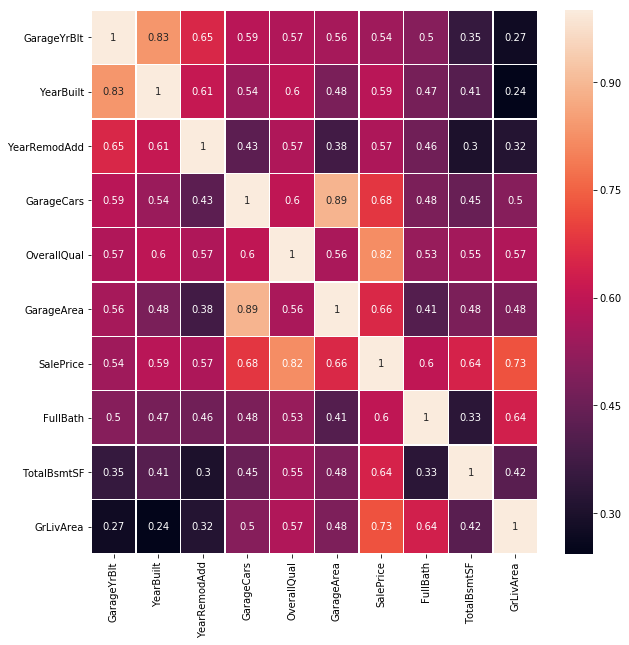

In [223]:
#GarageYrBlt
feature_corr(df_feature,'GarageYrBlt')  #有强相关性的

df_feature[['GarageYrBlt','YearBuilt']]  #查看，基本上GarageYrBlt=YearBuilt

for i in df_feature.index:
    if str(df_feature.loc[i,'GarageYrBlt'])=='nan':     #配合列的名称则必须用loc
            df_feature.loc[i,'GarageYrBlt']=df_feature.loc[i,'YearBuilt']

#结论：GarageYrBlt=YearBuilt

- test需要填充的特征，只能靠人工判断进行填充：
    - MSZoning:非数值型，按MSSubClass分组填充众数
    - Utilities:非数值型，填充众数
    - Exterior1st:非数值型，和Exterior2nd互相填充
    - Exterior2nd:非数值型，和Exterior1st互相填充
    - BsmtFinSF1:实际上为0，不存在地下室
    - BsmtFinSF2:实际上为0，不存在地下室
    - BsmtUnfSF:实际上为0，不存在地下室
    - TotalBsmtSF:实际上为0，不存在地下室
    - BsmtFullBath:实际上为0，不存在地下室
    - BsmtHalfBath:实际上为0，不存在地下室
    - KitchenQual:非数值型，填充众数
    - Functional:非数值型，填充众数
    - GarageCars:数值型，填充众数
    - GarageArea:数值型，填充众数
    - SaleType:非数值型，填充众数

In [224]:
df_feature['MSZoning']=feature_missing(df_feature,feature='MSZoning',feature_refer='MSSubClass',method='mode')

df_feature['Utilities']=feature_missing(df_feature,feature='Utilities',method='mode')

for i in df_feature.index:
    if str(df_feature.loc[i,'Exterior1st'])=='nan':     #配合列的名称则必须用loc
            df_feature.loc[i,'Exterior1st']=df_feature.loc[i,'Exterior2nd']
for i in df_feature.index:
    if str(df_feature.loc[i,'Exterior2nd'])=='nan':     #配合列的名称则必须用loc
            df_feature.loc[i,'Exterior2nd']=df_feature.loc[i,'Exterior1st']            
# df_feature['Exterior1st'].value_counts().sum()
# df_feature['Exterior2nd'].value_counts().sum()
# 检查出来还剩一项空值，用众数填充
df_feature['Exterior1st']=feature_missing(df_feature,feature='Exterior1st',method='mode')
df_feature['Exterior2nd']=feature_missing(df_feature,feature='Exterior2nd',method='mode')

# df_feature.BsmtFinSF1[df_feature.BsmtFinSF1.isnull()]
# df_feature.BsmtFinSF2[df_feature.BsmtFinSF2.isnull()]
# df_feature[['BsmtQual','BsmtCond','BsmtFinSF1','BsmtFinSF2']].loc[2121]
#检查出来其实是0值
df_feature['BsmtFinSF1']=df_feature['BsmtFinSF1'].fillna(0)
df_feature['BsmtFinSF2']=df_feature['BsmtFinSF2'].fillna(0)
df_feature['BsmtUnfSF']=df_feature['BsmtUnfSF'].fillna(0)
df_feature['TotalBsmtSF']=df_feature['TotalBsmtSF'].fillna(0)
df_feature['BsmtFullBath']=df_feature['TotalBsmtSF'].fillna(0)
df_feature['BsmtHalfBath']=df_feature['TotalBsmtSF'].fillna(0)

df_feature['KitchenQual']=feature_missing(df_feature,feature='KitchenQual',method='mode')
df_feature['Functional']=feature_missing(df_feature,feature='Functional',method='mode')


#feature_corr(df_feature,'GarageCars')  #GarageCars和GarageArea强相关，但正好两个都是空值，但偏偏又有车库。。。
# df_feature.GarageArea[df_feature.GarageArea.isnull()]
# df_feature.GarageCars[df_feature.GarageCars.isnull()]
# df_feature.GarageType[df_feature.GarageCars.isnull()]
df_feature['GarageCars']=feature_missing(df_feature,feature='GarageCars',method='mode')
df_feature['GarageArea']=feature_missing(df_feature,feature='GarageArea',method='mode')


df_feature['SaleType']=feature_missing(df_feature,feature='SaleType',method='mode')


In [129]:
pd.get_dummies(df_new).shape 
pd.get_dummies(df_feature).shape  #维度突然多了这么多，检查一下,发现多的维度是有几个转化成字符串的维度


(2899, 318)

In [69]:
model_eval(reg,pd.get_dummies(df_feature).iloc[:1440].sample(frac=1,random_state=10).drop('SalePrice',axis=1),
           pd.get_dummies(df_feature).iloc[:1440].sample(frac=1,random_state=10).SalePrice)

[0.13615947245315504, 0.11460311506298314, 0.11621363216366792, 0.10738288732368312, 0.12922691867327876, 0.12465515074450413, 0.12747675829042587, 0.13262995551537518, 0.12532720790465215, 0.11590893970902448]
0.122958403784075




0.122958403784075

In [70]:
outpath='%s//reg//1214//'%path
reg.fit(pd.get_dummies(df_feature).iloc[:1440].sample(frac=1,random_state=10).drop('SalePrice',axis=1),
        pd.get_dummies(df_feature).iloc[:1440].sample(frac=1,random_state=10).SalePrice)
model_predict(reg,pd.get_dummies(df_feature).iloc[1440:].drop('SalePrice',axis=1),outpath)  

- 模型成绩仍在0.123附近，实际成绩由0.13634降为0.13596，说明缺失值填充对模型精度提高很有限，而且在填充过程中你并不能确定哪一种方法是最好的。

In [73]:
#试一下LotFrontage 以自身均值填充


df_new=df.drop(index=outliers_listid)  #因为上面一步在测算模型的时候进行了填充，所以得重新更新下
 
df_feature1=pd.concat([df_new,df_test],axis=0)
df_feature1=df_feature1[df_new.columns]   #columns被打乱，重新排一下

df_feature1['MSSubClass'] = df_feature1['MSSubClass'].apply(str)
df_feature1['YrSold'] = df_feature1['YrSold'].astype(str)
df_feature1['MoSold'] = df_feature1['MoSold'].astype(str)

df_feature1['MasVnrType']=df_feature1['MasVnrType'].fillna('None')
df_feature1['MasVnrArea']=df_feature1['MasVnrArea'].fillna(0)

df_feature1['LotFrontage']=feature_missing(df_feature1,'LotFrontage',method='mean')

df_feature1['Electrical'].fillna('SBrkr')

for i in df_feature1.index:
    if str(df_feature1.loc[i,'GarageYrBlt'])=='nan':     #配合列的名称则必须用loc
            df_feature1.loc[i,'GarageYrBlt']=df_feature1.loc[i,'YearBuilt']

df_feature1['MSZoning']=feature_missing(df_feature1,feature='MSZoning',feature_refer='MSSubClass',method='mode')

df_feature1['Utilities']=feature_missing(df_feature1,feature='Utilities',method='mode')

for i in df_feature1.index:
    if str(df_feature1.loc[i,'Exterior1st'])=='nan':     #配合列的名称则必须用loc
            df_feature1.loc[i,'Exterior1st']=df_feature1.loc[i,'Exterior2nd']
for i in df_feature1.index:
    if str(df_feature1.loc[i,'Exterior2nd'])=='nan':     #配合列的名称则必须用loc
            df_feature1.loc[i,'Exterior2nd']=df_feature1.loc[i,'Exterior1st']            
# df_feature['Exterior1st'].value_counts().sum()
# df_feature['Exterior2nd'].value_counts().sum()
# 检查出来还剩一项空值，用众数填充
df_feature1['Exterior1st']=feature_missing(df_feature1,feature='Exterior1st',method='mode')
df_feature1['Exterior2nd']=feature_missing(df_feature1,feature='Exterior2nd',method='mode')

# df_feature.BsmtFinSF1[df_feature.BsmtFinSF1.isnull()]
# df_feature.BsmtFinSF2[df_feature.BsmtFinSF2.isnull()]
# df_feature[['BsmtQual','BsmtCond','BsmtFinSF1','BsmtFinSF2']].loc[2121]
#检查出来其实是0值
df_feature1['BsmtFinSF1']=df_feature1['BsmtFinSF1'].fillna(0)
df_feature1['BsmtFinSF2']=df_feature1['BsmtFinSF2'].fillna(0)
df_feature1['BsmtUnfSF']=df_feature1['BsmtUnfSF'].fillna(0)
df_feature1['TotalBsmtSF']=df_feature1['TotalBsmtSF'].fillna(0)
df_feature1['BsmtFullBath']=df_feature1['TotalBsmtSF'].fillna(0)
df_feature1['BsmtHalfBath']=df_feature1['TotalBsmtSF'].fillna(0)

df_feature1['KitchenQual']=feature_missing(df_feature1,feature='KitchenQual',method='mode')
df_feature1['Functional']=feature_missing(df_feature1,feature='Functional',method='mode')


#feature_corr(df_feature,'GarageCars')  #GarageCars和GarageArea强相关，但正好两个都是空值，但偏偏又有车库。。。
# df_feature.GarageArea[df_feature.GarageArea.isnull()]
# df_feature.GarageCars[df_feature.GarageCars.isnull()]
# df_feature.GarageType[df_feature.GarageCars.isnull()]
df_feature1['GarageCars']=feature_missing(df_feature1,feature='GarageCars',method='mode')
df_feature1['GarageArea']=feature_missing(df_feature1,feature='GarageArea',method='mode')


df_feature1['SaleType']=feature_missing(df_feature1,feature='SaleType',method='mode')


model_eval(reg,pd.get_dummies(df_feature1).iloc[:1440].sample(frac=1,random_state=10).drop('SalePrice',axis=1),
           pd.get_dummies(df_feature1).iloc[:1440].sample(frac=1,random_state=10).SalePrice)


outpath='%s//reg//1215//1//'%path
reg.fit(pd.get_dummies(df_feature1).iloc[:1440].sample(frac=1,random_state=10).drop('SalePrice',axis=1),
        pd.get_dummies(df_feature1).iloc[:1440].sample(frac=1,random_state=10).SalePrice)
model_predict(reg,pd.get_dummies(df_feature1).iloc[1440:].drop('SalePrice',axis=1),outpath)

#结论：实际成绩没有任何提升

In [75]:
#试一下LotFrontage 以Neighborhood中位数填充



df_new=df.drop(index=outliers_listid)  #因为上面一步在测算模型的时候进行了填充，所以得重新更新下
 
df_feature2=pd.concat([df_new,df_test],axis=0)
df_feature2=df_feature2[df_new.columns]   #columns被打乱，重新排一下

df_feature2['MSSubClass'] = df_feature2['MSSubClass'].apply(str)
df_feature2['YrSold'] = df_feature2['YrSold'].astype(str)
df_feature2['MoSold'] = df_feature2['MoSold'].astype(str)

df_feature2['MasVnrType']=df_feature2['MasVnrType'].fillna('None')
df_feature2['MasVnrArea']=df_feature2['MasVnrArea'].fillna(0)

df_feature2['LotFrontage']=feature_missing(df_feature2,'LotFrontage',feature_refer='Neighborhood',method='median')

df_feature2['Electrical'].fillna('SBrkr')

for i in df_feature2.index:
    if str(df_feature2.loc[i,'GarageYrBlt'])=='nan':     #配合列的名称则必须用loc
            df_feature2.loc[i,'GarageYrBlt']=df_feature2.loc[i,'YearBuilt']

df_feature2['MSZoning']=feature_missing(df_feature2,feature='MSZoning',feature_refer='MSSubClass',method='mode')

df_feature2['Utilities']=feature_missing(df_feature2,feature='Utilities',method='mode')

for i in df_feature2.index:
    if str(df_feature2.loc[i,'Exterior1st'])=='nan':     #配合列的名称则必须用loc
            df_feature2.loc[i,'Exterior1st']=df_feature2.loc[i,'Exterior2nd']
for i in df_feature1.index:
    if str(df_feature2.loc[i,'Exterior2nd'])=='nan':     #配合列的名称则必须用loc
            df_feature2.loc[i,'Exterior2nd']=df_feature2.loc[i,'Exterior1st']            
# df_feature['Exterior1st'].value_counts().sum()
# df_feature['Exterior2nd'].value_counts().sum()
# 检查出来还剩一项空值，用众数填充
df_feature2['Exterior1st']=feature_missing(df_feature2,feature='Exterior1st',method='mode')
df_feature2['Exterior2nd']=feature_missing(df_feature2,feature='Exterior2nd',method='mode')

# df_feature.BsmtFinSF1[df_feature.BsmtFinSF1.isnull()]
# df_feature.BsmtFinSF2[df_feature.BsmtFinSF2.isnull()]
# df_feature[['BsmtQual','BsmtCond','BsmtFinSF1','BsmtFinSF2']].loc[2121]
#检查出来其实是0值
df_feature2['BsmtFinSF1']=df_feature2['BsmtFinSF1'].fillna(0)
df_feature2['BsmtFinSF2']=df_feature2['BsmtFinSF2'].fillna(0)
df_feature2['BsmtUnfSF']=df_feature2['BsmtUnfSF'].fillna(0)
df_feature2['TotalBsmtSF']=df_feature2['TotalBsmtSF'].fillna(0)
df_feature2['BsmtFullBath']=df_feature2['TotalBsmtSF'].fillna(0)
df_feature2['BsmtHalfBath']=df_feature2['TotalBsmtSF'].fillna(0)

df_feature2['KitchenQual']=feature_missing(df_feature2,feature='KitchenQual',method='mode')
df_feature2['Functional']=feature_missing(df_feature2,feature='Functional',method='mode')


#feature_corr(df_feature,'GarageCars')  #GarageCars和GarageArea强相关，但正好两个都是空值，但偏偏又有车库。。。
# df_feature.GarageArea[df_feature.GarageArea.isnull()]
# df_feature.GarageCars[df_feature.GarageCars.isnull()]
# df_feature.GarageType[df_feature.GarageCars.isnull()]
df_feature2['GarageCars']=feature_missing(df_feature2,feature='GarageCars',method='mode')
df_feature2['GarageArea']=feature_missing(df_feature2,feature='GarageArea',method='mode')


df_feature2['SaleType']=feature_missing(df_feature2,feature='SaleType',method='mode')


model_eval(reg,pd.get_dummies(df_feature2).iloc[:1440].sample(frac=1,random_state=10).drop('SalePrice',axis=1),
           pd.get_dummies(df_feature2).iloc[:1440].sample(frac=1,random_state=10).SalePrice)


outpath='%s//reg//1215//2//'%path
reg.fit(pd.get_dummies(df_feature2).iloc[:1440].sample(frac=1,random_state=10).drop('SalePrice',axis=1),
        pd.get_dummies(df_feature2).iloc[:1440].sample(frac=1,random_state=10).SalePrice)
model_predict(reg,pd.get_dummies(df_feature2).iloc[1440:].drop('SalePrice',axis=1),outpath)

#结论：实际成绩由0.13596升为0.13637，表明参考的该种方法也不可取。缺失值填充在特征工程中的作用有限

[0.10652063492632141, 0.11760949370123276, 0.12145559388079455, 0.13147017552647086, 0.13374147525501331, 0.10099099971528501, 0.10791719056315058, 0.11754058696298107, 0.13233047394526873, 0.15461154970532415]
0.12241881741818424




In [227]:
#数值型数据列偏度矫正
df_feature3=df_feature


numeric_features=df_feature3.drop('SalePrice',axis=1).dtypes[df_feature3.dtypes!=object].index  #有的原本是数值型，被变换为非数值型了，所以要修正一下
df_feature3[numeric_features].skew()

#测试一下哪一个阈值最合适
for thre in np.arange(0.1,1.01,0.05):
    print(('threshold=%.2f')%thre)
    
    df_feature3=df_feature
    highskew_index=df_feature3[numeric_features].skew()[df_feature3[numeric_features].skew() >=thre].index  
    for i in highskew_index:
        df_feature3[i] = boxcox1p(df_feature3[i], boxcox_normmax(df_feature3[i] + 1))
    model_eval(reg,pd.get_dummies(df_feature3).iloc[:1440].sample(frac=1,random_state=10).drop('SalePrice',axis=1),
           pd.get_dummies(df_feature3).iloc[:1440].sample(frac=1,random_state=10).SalePrice)

#结论：其实是否进行偏度矫正、或者选哪个阈值进行矫正，影响都不大- -

In [228]:
df_feature3=df_feature
highskew_index=df_feature3[numeric_features].skew()[df_feature3[numeric_features].skew() >0.15].index
for i in highskew_index:
    df_feature3[i] = boxcox1p(df_feature3[i], boxcox_normmax(df_feature3[i] + 1))

outpath='%s//reg//1215//3//'%path
reg.fit(pd.get_dummies(df_feature3).iloc[:1440].sample(frac=1,random_state=10).drop('SalePrice',axis=1),
        pd.get_dummies(df_feature3).iloc[:1440].sample(frac=1,random_state=10).SalePrice)
model_predict(reg,pd.get_dummies(df_feature3).iloc[1440:].drop('SalePrice',axis=1),outpath)

In [ ]:
#结论：实际成绩由0.13596升为0.13613，表明偏态矫正在并没有取得良好的效果

In [273]:
#特征删除
df_feature3.Utilities.value_counts()
df_feature3.Street.value_counts()
df_feature3.PoolQC.value_counts()
df_feature3.Fence.value_counts()
df_feature3.FireplaceQu.value_counts()
df_feature3.MiscFeature.value_counts()

#上面几个特征缺失率都太高了
df_feature4=df_feature3.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
# model_eval(reg,pd.get_dummies(df_feature4).iloc[:1440].sample(frac=1,random_state=10).drop('SalePrice',axis=1),
#            pd.get_dummies(df_feature4).iloc[:1440].sample(frac=1,random_state=10).SalePrice)

# outpath='%s//reg//1215//4//'%path
# reg.fit(pd.get_dummies(df_feature4).iloc[:1440].sample(frac=1,random_state=10).drop('SalePrice',axis=1),
#         pd.get_dummies(df_feature4).iloc[:1440].sample(frac=1,random_state=10).SalePrice)
# model_predict(reg,pd.get_dummies(df_feature4).iloc[1440:].drop('SalePrice',axis=1),outpath)


df_feature5=df_feature3.drop(['Utilities', 'Street', 'PoolQC','MiscFeature', 'Alley', 'Fence'], axis=1)
# model_eval(reg,pd.get_dummies(df_feature5).iloc[:1440].sample(frac=1,random_state=10).drop('SalePrice',axis=1),
#            pd.get_dummies(df_feature5).iloc[:1440].sample(frac=1,random_state=10).SalePrice)

# outpath='%s//reg//1215//5//'%path
# reg.fit(pd.get_dummies(df_feature5).iloc[:1440].sample(frac=1,random_state=10).drop('SalePrice',axis=1),
#         pd.get_dummies(df_feature5).iloc[:1440].sample(frac=1,random_state=10).SalePrice)
# model_predict(reg,pd.get_dummies(df_feature5).iloc[1440:].drop('SalePrice',axis=1),outpath)


#结论：df_feature5实际成绩由0.13596升为0.13615，也没有太大作用

In [296]:
#融合生成新特征
df_feature6=df_feature5.copy()   #为什么一定要copy？？？不用copy，对df_feature6的更改会影响df_feature5.。。疑问？？

df_feature6['HasWoodDeck'] = (df_feature6['WoodDeckSF'] == 0) * 1
df_feature6['HasOpenPorch'] = (df_feature6['OpenPorchSF'] == 0) * 1
df_feature6['HasEnclosedPorch'] = (df_feature6['EnclosedPorch'] == 0) * 1
df_feature6['Has3SsnPorch'] = (df_feature6['3SsnPorch'] == 0) * 1
df_feature6['HasScreenPorch'] = (df_feature6['ScreenPorch'] == 0) * 1
df_feature6['YearsSinceRemodel'] = df_feature6['YrSold'].astype(int) - df_feature6['YearRemodAdd'].astype(int)
df_feature6['Total_Home_Quality'] = df_feature6['OverallQual'] + df_feature6['OverallCond']
df_feature6['TotalSF'] = df_feature6['TotalBsmtSF'] + df_feature6['1stFlrSF'] + df_feature6['2ndFlrSF']
df_feature6['YrBltAndRemod'] = df_feature6['YearBuilt'] + df_feature6['YearRemodAdd']
df_feature6['Total_sqr_footage'] = (df_feature6['BsmtFinSF1'] + df_feature6['BsmtFinSF2'] +
                                 df_feature6['1stFlrSF'] + df_feature6['2ndFlrSF'])
df_feature6['Total_Bathrooms'] = (df_feature6['FullBath'] + (0.5 * df_feature6['HalfBath']) +
                               df_feature6['BsmtFullBath'] + (0.5 * df_feature6['BsmtHalfBath']))
df_feature6['Total_porch_sf'] = (df_feature6['OpenPorchSF'] + df_feature6['3SsnPorch'] +
                              df_feature6['EnclosedPorch'] + df_feature6['ScreenPorch'] +
                              df_feature6['WoodDeckSF'])
df_feature6['YrBltAndRemod']=df_feature6['YearBuilt']+df_feature6['YearRemodAdd']
df_feature6['TotalSF']=df_feature6['TotalBsmtSF'] + df_feature6['1stFlrSF'] + df_feature6['2ndFlrSF']

df_feature6['Total_sqr_footage'] = (df_feature6['BsmtFinSF1'] + df_feature6['BsmtFinSF2'] +
                                 df_feature6['1stFlrSF'] + df_feature6['2ndFlrSF'])

df_feature6['Total_Bathrooms'] = (df_feature6['FullBath'] + (0.5 * df_feature6['HalfBath']) +
                               df_feature6['BsmtFullBath'] + (0.5 * df_feature6['BsmtHalfBath']))

df_feature6['Total_porch_sf'] = (df_feature6['OpenPorchSF'] + df_feature6['3SsnPorch'] +
                              df_feature6['EnclosedPorch'] + df_feature6['ScreenPorch'] +
                              df_feature6['WoodDeckSF'])

# model_eval(reg,pd.get_dummies(df_feature6).iloc[:1440].sample(frac=1,random_state=10).drop('SalePrice',axis=1),
#            pd.get_dummies(df_feature6).iloc[:1440].sample(frac=1,random_state=10).SalePrice)
#结论：模型提升没什么用

In [ ]:
#融合生成新特征
df_feature6=df_feature5.copy()   #为什么一定要copy？？？不用copy，对df_feature6的更改会影响df_feature5.。。疑问？？

df_feature6['HasWoodDeck'] = (df_feature6['WoodDeckSF'] == 0) * 1
df_feature6['HasOpenPorch'] = (df_feature6['OpenPorchSF'] == 0) * 1
df_feature6['HasEnclosedPorch'] = (df_feature6['EnclosedPorch'] == 0) * 1
df_feature6['Has3SsnPorch'] = (df_feature6['3SsnPorch'] == 0) * 1
df_feature6['HasScreenPorch'] = (df_feature6['ScreenPorch'] == 0) * 1
df_feature6['YearsSinceRemodel'] = df_feature6['YrSold'].astype(int) - df_feature6['YearRemodAdd'].astype(int)
df_feature6['Total_Home_Quality'] = df_feature6['OverallQual'] + df_feature6['OverallCond']
df_feature6['TotalSF'] = df_feature6['TotalBsmtSF'] + df_feature6['1stFlrSF'] + df_feature6['2ndFlrSF']
df_feature6['YrBltAndRemod'] = df_feature6['YearBuilt'] + df_feature6['YearRemodAdd']
df_feature6['Total_sqr_footage'] = (df_feature6['BsmtFinSF1'] + df_feature6['BsmtFinSF2'] +
                                 df_feature6['1stFlrSF'] + df_feature6['2ndFlrSF'])
df_feature6['Total_Bathrooms'] = (df_feature6['FullBath'] + (0.5 * df_feature6['HalfBath']) +
                               df_feature6['BsmtFullBath'] + (0.5 * df_feature6['BsmtHalfBath']))
df_feature6['Total_porch_sf'] = (df_feature6['OpenPorchSF'] + df_feature6['3SsnPorch'] +
                              df_feature6['EnclosedPorch'] + df_feature6['ScreenPorch'] +
                              df_feature6['WoodDeckSF'])
df_feature6['YrBltAndRemod']=df_feature6['YearBuilt']+df_feature6['YearRemodAdd']
df_feature6['TotalSF']=df_feature6['TotalBsmtSF'] + df_feature6['1stFlrSF'] + df_feature6['2ndFlrSF']

df_feature6['Total_sqr_footage'] = (df_feature6['BsmtFinSF1'] + df_feature6['BsmtFinSF2'] +
                                 df_feature6['1stFlrSF'] + df_feature6['2ndFlrSF'])

df_feature6['Total_Bathrooms'] = (df_feature6['FullBath'] + (0.5 * df_feature6['HalfBath']) +
                               df_feature6['BsmtFullBath'] + (0.5 * df_feature6['BsmtHalfBath']))

df_feature6['Total_porch_sf'] = (df_feature6['OpenPorchSF'] + df_feature6['3SsnPorch'] +
                              df_feature6['EnclosedPorch'] + df_feature6['ScreenPorch'] +
                              df_feature6['WoodDeckSF'])

# model_eval(reg,pd.get_dummies(df_feature6).iloc[:1440].sample(frac=1,random_state=10).drop('SalePrice',axis=1),
#            pd.get_dummies(df_feature6).iloc[:1440].sample(frac=1,random_state=10).SalePrice)
#结论：没有显著效果

In [303]:
#简化特征，对于某些分布单调（比如100个数据中有99个的数值是0.9，另1个是0.1）的数字型数据列，进行01取值处理。
#要确保其他字段没有包含这部分信息，比如有一个字段专门表示有无pool的，那就不用额外生成
df_feature7=df_feature6.copy()

#PoolArea: unique      13, top          0, freq      2905/2917
#2ndFlrSF: unique      633, top          0, freq      1668/2917
#2ndFlrSF: unique      5, top          0, freq      1420/2917
df_feature7['haspool'] = df_feature7['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_feature7['has2ndfloor'] = df_feature7['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df_feature7['hasgarage'] = df_feature7['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_feature7['hasbsmt'] = df_feature7['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_feature7['hasfireplace'] = df_feature7['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

model_eval(reg,pd.get_dummies(df_feature7).iloc[:1440].sample(frac=1,random_state=10).drop('SalePrice',axis=1),
           pd.get_dummies(df_feature7).iloc[:1440].sample(frac=1,random_state=10).SalePrice)
# outpath='%s//reg//1215//7//'%path
# model_predict(reg,pd.get_dummies(df_feature7).iloc[1440:].drop('SalePrice',axis=1),outpath)

#结论：实际成绩提升到0.13299，可能是前面几个步骤的综合作用，当然也可能只是模型的随机波动

[0.11629032327028566, 0.1289224995587431, 0.13510531546041946, 0.09319722196771123, 0.11162341886064212, 0.11917990249610308, 0.11063615110212766, 0.10493593095496186, 0.14414795012047715, 0.1485970461454582]
0.12126357599369295




0.12126357599369295

In [378]:
#get_dummies并删除单一特征（比如某个值出现了99%以上）的特征
print("before get_dummies:",df_feature7.shape)

df_feature_final = pd.get_dummies(df_feature7)
print("after get_dummies:",df_feature_final.shape)

X_train=df_feature_final.iloc[:1440].sample(frac=1,random_state=10).drop('SalePrice',axis=1)
y_train=pd.DataFrame(df_feature_final.iloc[:1440].sample(frac=1,random_state=10).SalePrice)  #不然会变成series
X_test=df_feature_final.iloc[1440:].drop('SalePrice',axis=1)


##删除单一特征，但模型结果无差异，毕竟xgboost本身就具备筛掉不重要的特征的功能，所以这里不进行单一特征删除
# for thre in np.arange(99.8,100,0.02):
#     overfit = []
#     for i in X_train.columns:
#         counts = X_train[i].value_counts()
#         zeros = counts.iloc[0]
#         if zeros / len(X_train) * 100 > thre: #99.94是可以调整的，80,90,95，99...
#             overfit.append(i)
#     print('thre',thre)
#     print(overfit)
#     model_eval(reg,X_train.drop(overfit,axis=1),y_train)

print('X_train', X_train.shape, 'y_train', y_train.shape, 'X_test', X_test.shape)

print('feature engineering finished!')




#结论，特征工程里面最有效的步骤是异常值筛选，然后把原始的0.139的成绩提升为0.133~0.135之间

before get_dummies: (2899, 91)
after get_dummies: (2899, 318)
X_train (1440, 317) y_train (1440, 1) X_test (1459, 317)
feature engineering finished!


In [379]:
X_train.to_csv('%sX_train.csv'%path)
y_train.to_csv('%sy_train.csv'%path)
X_test.to_csv('%sX_test.csv'%path)

三、训练模型

In [380]:
X_train=pd.read_csv('%sX_train.csv'%path,index_col='Id')
y_train=pd.read_csv('%sy_train.csv'%path,index_col='Id')
X_test=pd.read_csv('%sX_test.csv'%path,index_col='Id')

- 3.1 single model ：lasso\rideg\elastic net\svr\gdbt\lightgbm\xgb

In [647]:
# 函数定义：
def find_cv(model,X_train,y_train,param_test):
    model_cv=model_selection.GridSearchCV(model,param_test,cv=10,n_jobs=-1,scoring='neg_mean_squared_error')
    model_cv.fit(X_train,y_train)

    print("model_cv.cv_results_['mean_test_score']:=%s"%np.sqrt(-model_cv.cv_results_['mean_test_score']))  #结果是开根号值

    print()
    print(np.sqrt(-model_cv.best_score_))
    print(model_cv.best_params_)

In [701]:
# lasso
reg_lasso=linear_model.Lasso(random_state=10)  #默认alpha=1

param_test = {
 'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100]
}

find_cv(reg_lasso,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.11735836 0.11139317 0.11173533 0.13778104 0.17802509 0.18454608
 0.22280442 0.38420547]

0.11139316743510164
{'alpha': 0.0001}


In [705]:
# lasso win
reg_lasso=linear_model.Lasso()  #默认alpha=1

param_test = {
 'alpha':[0.00008,0.0001,0.0002,0.0005,0.0008]
}

find_cv(reg_lasso,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.11217991 0.11139317 0.10949825 0.10924296 0.11066832]

0.1092429556918078
{'alpha': 0.0005}


In [706]:
# lasso 
reg_lasso=linear_model.Lasso(random_state=10)  #默认alpha=1

param_test = {
 'alpha':np.arange(0.00020,0.00070,0.00005)
}

find_cv(reg_lasso,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.10949825 0.10912085 0.10890688 0.10882529 0.10886334 0.10903324
 0.10924296 0.10942558 0.1096334  0.10985683]

0.10882529476622223
{'alpha': 0.00035}


In [718]:
# lasso win
reg_lasso=linear_model.Lasso(random_state=10)  #默认alpha=1

param_test = {
 'alpha':np.arange(0.00030,0.00040,0.00001)
}

find_cv(reg_lasso,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.10890688 0.10887805 0.10885498 0.10884216 0.10883116 0.10882529
 0.10882174 0.10882047 0.10882789 0.10884186 0.10886334]

0.10882046742335715
{'alpha': 0.00037000000000000016}


In [750]:
# lasso win
model=linear_model.Lasso(0.00037,random_state=10)
model_eval(model,X_train,y_train)

#模型预测
outpath='%s//reg//1220//lasso//'%path
model_predict(model.fit(X_train,y_train),X_test,outpath)  

#实际成绩 0.11658

[0.09433748332213278, 0.09727685917576501, 0.1140091377645821, 0.09498002495455958, 0.09712061538975443, 0.0853551028079518, 0.13622587801927544, 0.11595717958751381, 0.1248013023804026, 0.11721977074126069]
0.10772833541431984




In [725]:
# ridge
reg_ridge=linear_model.Ridge(random_state=10)  #默认alpha=1

param_test = {
 'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100]
}

find_cv(reg_ridge,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.1189829  0.11896851 0.11893846 0.11876695 0.11736075 0.11310117
 0.10983591 0.11589001]

0.1098359144052653
{'alpha': 10}


In [726]:
# ridge
reg_ridge=linear_model.Ridge(random_state=10)  #默认alpha=1

param_test = {
 'alpha':[2,5,10,20,50]
}

find_cv(reg_ridge,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.11156875 0.11011441 0.10983591 0.11048751 0.1129035 ]

0.1098359144052653
{'alpha': 10}


In [727]:
# ridge
reg_ridge=linear_model.Ridge(random_state=10)  #默认alpha=1

param_test = {
 'alpha':np.arange(5,15,0.5)
}

find_cv(reg_ridge,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.11011441 0.11002695 0.10995996 0.10990956 0.10987276 0.10984726
 0.10983122 0.10982316 0.10982188 0.1098264  0.10983591 0.10984973
 0.10986728 0.10988808 0.10991172 0.10993783 0.10996612 0.10999631
 0.11002819 0.11006154]

0.1098218795895249
{'alpha': 9.0}


In [751]:
model=linear_model.Ridge(9,random_state=10)
model_eval(model,X_train,y_train)

#模型预测
outpath='%s//reg//1220//ridge//'%path
y_test_pred=model.fit(X_train,y_train).predict(X_test)
SalePrice_pred=np.exp(y_test_pred)
df_reg=pd.DataFrame({'Id':X_test.index,'SalePrice':SalePrice_pred2.reshape(1,-1)[0]}).set_index('Id')  #ridge模型自己怪。。生成的结果不是标准格式
df_reg.to_csv('%stest_pred.csv'%outpath)
#实际成绩 0.11668

[0.09729766836689094, 0.10096677702588819, 0.1132026429484733, 0.09517026601837879, 0.09799305970519953, 0.09017859023785658, 0.1392624723402209, 0.11271543002515284, 0.12240339348288416, 0.11941061567863859]
0.1088600915829584




In [729]:
# ela
reg_ela=linear_model.ElasticNet(random_state=10)  #默认alpha=1,l1_ratio=0.5

param_test = {
 'alpha':[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007],
  'l1_ratio':np.arange(0.5,1.1,0.05)
}

find_cv(reg_ela,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.11359631 0.11331632 0.11305487 0.11279976 0.11254511 0.1122961
 0.11209829 0.11190726 0.11173195 0.11156811 0.11139317 0.11122569
 0.11108286 0.11109547 0.11083184 0.11061562 0.1104199  0.11025952
 0.11012027 0.10998157 0.10983337 0.10970796 0.10960016 0.10949825
 0.10940131 0.10932768 0.10996963 0.10977475 0.10959098 0.10945005
 0.10931874 0.10922955 0.10915717 0.10907359 0.10900864 0.10895148
 0.10890688 0.10886574 0.10884516 0.10933061 0.10919952 0.10911367
 0.10901785 0.10894596 0.10889149 0.10884646 0.10882868 0.10882191
 0.10882906 0.10886334 0.10891666 0.10899071 0.1090316  0.10894651
 0.10888114 0.10883632 0.10882597 0.10883171 0.10887285 0.10894355
 0.10903816 0.10913977 0.10924296 0.10932676 0.10941498 0.10887516
 0.10883362 0.10883105 0.10886559 0.1089372  0.10905018 0.10917464
 0.1092966  0.10939946 0.10951702 0.1096334  0.10975969 0.10988455
 0.10883799 0.10886841 0.10895177 0.10908493 0.10923324 0.10936788
 0.10949885 0.10963606

In [730]:
# ela
reg_ela=linear_model.ElasticNet(random_state=10)  #默认alpha=1,l1_ratio=0.5

param_test = {
 'alpha':np.arange(0.000385,0.000410,0.000005),
  'l1_ratio':np.arange(0.93,0.95,0.01)
}

find_cv(reg_ela,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.10882271 0.10882111 0.1088208  0.10882011 0.10882044 0.10882259
 0.10882342 0.10882582 0.1088266  0.10882997 0.10883085 0.10883606]

0.10882010673069459
{'alpha': 0.00039, 'l1_ratio': 0.9400000000000001}


In [752]:
model=linear_model.ElasticNet(0.00039,0.95,random_state=10)
model_eval(model,X_train,y_train)

#模型预测
outpath='%s//reg//1220//ela//'%path
model_predict(model.fit(X_train,y_train),X_test,outpath)  
#实际成绩 0.11775

[0.09433554970611241, 0.0973013807826337, 0.1139896577665552, 0.09496446513079224, 0.09712178496677563, 0.08536510198272912, 0.13626624552045974, 0.11594800309156858, 0.12477609018274481, 0.11722516747913561]
0.10772934466095072




In [735]:
#svr  svr没有随机种子
re_svr=svm.SVR()  #默认c=1,gamma='auto_deprecated'

param_test = {
  'gamma':[1e-09,1e-08,1e-07,1e-06,1e-05,1e-04,1e-03,1e-02,1e-01,1,]
}

find_cv(re_svr,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.25411021 0.20209096 0.17889549 0.17181585 0.19830305 0.28408289
 0.38190248 0.3957777  0.39682894 0.39705251]

0.17181585122843065
{'gamma': 1e-06}


In [737]:
#svr  svr没有随机种子
re_svr=svm.SVR()  #默认c=1,gamma='auto_deprecated'

param_test = {
  'C':[0.01,0.1,1,10,100,1000],
  'gamma':[1e-07,1e-06,1e-05]
}

find_cv(re_svr,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.26258915 0.23709474 0.29665802 0.20096356 0.19448236 0.22241755
 0.17889549 0.17181585 0.19830305 0.16979777 0.17055403 0.20727439
 0.16060959 0.1639791  0.21631231 0.14345376 0.18273383 0.22188485]

0.1434537606494319
{'C': 1000, 'gamma': 1e-07}


In [738]:
#svr  svr没有随机种子
re_svr=svm.SVR()  #默认c=1,gamma='auto_deprecated'

param_test = {
  'C':[500,1000,2000,10000],
  'gamma':[1e-08,1e-07,1e-06]
}

find_cv(re_svr,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.16624086 0.14954524 0.17164292 0.16054801 0.14345376 0.18273383
 0.15394039 0.13638112 0.19048165 0.13478135 0.12698652 0.20493905]

0.12698652034917302
{'C': 10000, 'gamma': 1e-07}


In [739]:
#svr  svr没有随机种子
re_svr=svm.SVR()  #默认c=1,gamma='auto_deprecated'

param_test = {
  'C':[10000,25000,50000],
  'gamma':[1e-08,1e-07,1e-06]
}

find_cv(re_svr,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.13478135 0.12698652 0.20493905 0.12657716 0.12976152 0.22975655
 0.12281381 0.13708514 0.23736199]

0.12281380559594028
{'C': 50000, 'gamma': 1e-08}


In [742]:
#svr  svr没有随机种子
re_svr=svm.SVR()  #默认c=1,gamma='auto_deprecated'

param_test = {
  'C':[35000,50000,80000,100000],
  'gamma':[1e-09,1e-08,1e-07]
}

find_cv(re_svr,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.15043652 0.12413841 0.13363378 0.14526819 0.12281381 0.13708514
 0.13902187 0.11972456 0.13773909 0.13615036 0.11826792 0.13995297]

0.11826792157936354
{'C': 100000, 'gamma': 1e-08}


In [743]:
#svr  svr没有随机种子
re_svr=svm.SVR()  #默认c=1,gamma='auto_deprecated'

param_test = {
  'C':[100000,150000],
  'gamma':[1e-08]
}

find_cv(re_svr,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.11826792 0.11706823]

0.11706822682488391
{'C': 150000, 'gamma': 1e-08}


In [744]:
#svr  svr没有随机种子
re_svr=svm.SVR()  #默认c=1,gamma='auto_deprecated'

param_test = {
  'C':[125000,200000],
  'gamma':[1e-08]
}

find_cv(re_svr,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.11673586 0.12034765]

0.11673586101063398
{'C': 125000, 'gamma': 1e-08}


In [734]:
model=svm.SVR(gamma=1e-08,C=25000)
model_eval(model,X_train,y_train)

#模型预测
outpath='%s//reg//1220//svr//'%path
model_predict(model,X_test,outpath)  
#实际成绩 0.12689 

[0.11948206981895286, 0.12117397871844446, 0.12079342592246656, 0.09705721924624156, 0.1037586546211114, 0.11929079954077036, 0.16041756219636155, 0.14132229000751995, 0.13456057325235446, 0.13579045380167548]
0.12536470271258987




In [753]:
model=svm.SVR(gamma=1e-08,C=125000)
model_eval(model,X_train,y_train)

#模型预测
outpath='%s//reg//1220//svr//'%path
model_predict(model.fit(X_train,y_train),X_test,outpath)  
#实际成绩 0.12521  

[0.10761526926499275, 0.11702584329735732, 0.11109367291304932, 0.09253152262151972, 0.09969807175881752, 0.10226802902802098, 0.15082911301998822, 0.12279702894335842, 0.12733821041804522, 0.12510245674107448]
0.11562992180062241




- 参数的影响这么大！！！！！

In [746]:
#gdbt  
#第一步是最重要的，所以要细一点
reg_gdbt=ensemble.GradientBoostingRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':range(1,10,1),
 'min_weight_fraction_leaf':[0.0001,0.001,0.01,0.1,0.5],    #不清楚GDBT里面权重的尺度一般是多少
#  'max_features':np.array([20]),      #为了提升速度
#  'learning_rate':np.array([0.3]),    #为了提升速度
}

find_cv(reg_gdbt,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.14335745 0.14335745 0.14384984 0.15193538 0.26234986 0.1255918
 0.12644695 0.12555008 0.13828294 0.26234986 0.12334083 0.12323995
 0.12334643 0.13507468 0.26234986 0.1245375  0.12378725 0.12306954
 0.13649831 0.26234986 0.12601048 0.12513861 0.12457794 0.13630506
 0.26234986 0.13031792 0.12824024 0.12745463 0.13670109 0.26234986
 0.13427916 0.13305401 0.12832821 0.13676403 0.26234986 0.14104065
 0.13803413 0.12816547 0.13636487 0.26234986 0.15116807 0.14287976
 0.12755655 0.13636487 0.26234986]

0.12306953994736002
{'max_depth': 4, 'min_weight_fraction_leaf': 0.01}


In [ ]:
#gdbt  
#第一步是最重要的，所以要细一点
reg_gdbt=ensemble.GradientBoostingRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':range(2,5,1),
 'min_weight_fraction_leaf':np.arange(0.002,0.007,0.0005),    #不清楚GDBT里面权重的尺度一般是多少
#  'max_features':np.array([20]),      #为了提升速度
#  'learning_rate':np.array([0.3]),    #为了提升速度
}

find_cv(reg_gdbt,X_train,y_train,param_test)

In [ ]:
#gdbt  
reg_gdbt=ensemble.GradientBoostingRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[3],
 'min_weight_fraction_leaf':[0.004],    #不清楚GDBT里面权重的尺度一般是多少
 'min_impurity_split':np.array([0,1e-7,1e-6,1e-5,1e-4,1e-3]), 
#  'max_features':np.array([20]),      #为了提升速度
#  'learning_rate':np.array([0.3]),    #为了提升速度
}

find_cv(reg_gdbt,X_train,y_train,param_test)

In [ ]:
#gdbt  
reg_gdbt=ensemble.GradientBoostingRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[3],
 'min_weight_fraction_leaf':[0.004],    #不清楚GDBT里面权重的尺度一般是多少
 'min_impurity_split':[0], 
 'subsample':np.arange(0.5,1.01,0.1),
 'max_features':[0.4,0.6,0.8,1],    
#  'learning_rate':np.array([0.3]),    #为了提升速度
}

find_cv(reg_gdbt,X_train,y_train,param_test)

In [ ]:
#gdbt  
reg_gdbt=ensemble.GradientBoostingRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[3],
 'min_weight_fraction_leaf':[0.004],    #不清楚GDBT里面权重的尺度一般是多少
 'min_impurity_split':[0], 
 'subsample':np.arange(0.76,0.85,0.02),
 'max_features':np.arange(0.3,0.51,0.05),    
#  'learning_rate':np.array([0.3]),    #为了提升速度
}

find_cv(reg_gdbt,X_train,y_train,param_test)

In [ ]:
#gdbt  
reg_gdbt=ensemble.GradientBoostingRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[3],
 'min_weight_fraction_leaf':[0.004],    #不清楚GDBT里面权重的尺度一般是多少
 'min_impurity_split':[0], 
 'subsample':[0.82],
 'max_features':[0.45],    
 'n_estimators':[50,100,500,1000,2000],
#  'learning_rate':np.array([0.3]),    #为了提升速度
}

find_cv(reg_gdbt,X_train,y_train,param_test)

In [ ]:
#gdbt  
reg_gdbt=ensemble.GradientBoostingRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[3],
 'min_weight_fraction_leaf':[0.004],    #不清楚GDBT里面权重的尺度一般是多少
 'min_impurity_split':[0], 
 'subsample':[0.82],
 'max_features':[0.45],    
 'n_estimators':range(470,490,2),
#  'learning_rate':np.array([0.3]),    #为了提升速度
}

find_cv(reg_gdbt,X_train,y_train,param_test)

In [ ]:
#gdbt  
reg_gdbt=ensemble.GradientBoostingRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[3],
 'min_weight_fraction_leaf':[0.004],    #不清楚GDBT里面权重的尺度一般是多少
 'min_impurity_split':[0], 
 'subsample':[0.82],
 'max_features':[0.45],    
 'n_estimators':[480],
 'learning_rate':[0.001,0.01,0.05,0.1,0.2,0.3]
}

find_cv(reg_gdbt,X_train,y_train,param_test)

In [ ]:
#gdbt  
reg_gdbt=ensemble.GradientBoostingRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[3],
 'min_weight_fraction_leaf':[0.004],    #不清楚GDBT里面权重的尺度一般是多少
 'min_impurity_split':[0], 
 'subsample':[0.82],
 'max_features':[0.45],    
 'n_estimators':[480],
 'learning_rate':[0.02,0.04,0.05,0.06,0.08],
}

find_cv(reg_gdbt,X_train,y_train,param_test)

In [ ]:
#gdbt  
reg_gdbt=ensemble.GradientBoostingRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[3],
 'min_weight_fraction_leaf':[0.004],    #不清楚GDBT里面权重的尺度一般是多少
 'min_impurity_split':[0], 
 'subsample':[0.82],
 'max_features':[0.45],    
 'n_estimators':[480],
 'learning_rate':np.arange(0.05,0.07,0.002),
}

find_cv(reg_gdbt,X_train,y_train,param_test)

In [ ]:
#gdbt  
reg_gdbt=ensemble.GradientBoostingRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[3],
 'min_weight_fraction_leaf':[0.004],    #不清楚GDBT里面权重的尺度一般是多少
 'min_impurity_split':[0], 
 'subsample':[0.82],
 'max_features':[0.45],    
 'n_estimators':[480],
 'learning_rate':np.arange(0.062,0.066,0.0005),
}

find_cv(reg_gdbt,X_train,y_train,param_test)

In [ ]:
#gdbt  
#最后来全局寻优
reg_gdbt=ensemble.GradientBoostingRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[2,3,4],
 'min_weight_fraction_leaf':[0.003,0.004,0.005],    #不清楚GDBT里面权重的尺度一般是多少
 'min_impurity_split':[0], 
 'subsample':[0.81,0.82,0.83],
 'max_features':[0.43,0.45,0.46],    
 'n_estimators':[480],
 'learning_rate':[0.064],
}

find_cv(reg_gdbt,X_train,y_train,param_test)

In [747]:
model=ensemble.GradientBoostingRegressor(
                                max_depth=3,
                                min_weight_fraction_leaf=0.004,
                                min_impurity_split=0,
                                subsample=0.82,
                                max_features=0.45,
                                n_estimators=480,
                                learning_rate=0.064,
                                random_state=10
                                )
model_eval(model,X_train,y_train)

#模型预测
outpath='%s//reg//1220//gdbt//'%path
model_predict(model,X_test,outpath)  
#实际成绩 0.13050

[0.09957111787656127, 0.11749588655215727, 0.11840365919717717, 0.0907194592726928, 0.09825935609923328, 0.09439247720181584, 0.14316262403496552, 0.11718249191632242, 0.12264663157401871, 0.12243821415751978]
0.11242719178824641




In [749]:
model=ensemble.GradientBoostingRegressor(
                                max_depth=3,
                                min_weight_fraction_leaf=0.004,
                                min_impurity_split=0,
                                subsample=0.82,
                                max_features=0.45,
                                n_estimators=480,
                                learning_rate=0.064,
                                random_state=10
                                )
# model_eval(model,X_train,y_train)

#模型预测
outpath='%s//reg//1220//gdbt//'%path
model_predict(model.fit(X_train,y_train),X_test,outpath)  
#实际成绩 0.13023

In [755]:
#lightgbm
reg_lgbm=lightgbm.LGBMRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':range(1,10,2),
 'num_leaves':[10,20,100,200]
}

find_cv(reg_lgbm,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.14335493 0.14335493 0.14335493 0.14335493 0.12132749 0.12132749
 0.12132749 0.12132749 0.12278128 0.12343666 0.1244235  0.1244235
 0.12169198 0.12390017 0.12529802 0.12529802 0.12175976 0.12376927
 0.12488079 0.12488079]

0.12132748841502379
{'max_depth': 3, 'num_leaves': 10}


In [764]:
#lightgbm
reg_lgbm=lightgbm.LGBMRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':range(1,10,1),
 'num_leaves':range(5,20,1)
}

find_cv(reg_lgbm,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.14335493 0.14335493 0.14335493 0.14335493 0.14335493 0.14335493
 0.14335493 0.14335493 0.14335493 0.14335493 0.14335493 0.14335493
 0.14335493 0.14335493 0.14335493 0.12659396 0.12659396 0.12659396
 0.12659396 0.12659396 0.12659396 0.12659396 0.12659396 0.12659396
 0.12659396 0.12659396 0.12659396 0.12659396 0.12659396 0.12659396
 0.1234015  0.12312224 0.1224435  0.12132749 0.12132749 0.12132749
 0.12132749 0.12132749 0.12132749 0.12132749 0.12132749 0.12132749
 0.12132749 0.12132749 0.12132749 0.12340818 0.12195626 0.12116625
 0.12262275 0.12202098 0.12275997 0.12239408 0.12359385 0.12200159
 0.12221332 0.12220178 0.12183416 0.12183416 0.12183416 0.12183416
 0.12340818 0.12217101 0.12101994 0.12197783 0.12159207 0.12278128
 0.12178428 0.12186498 0.12201668 0.12220863 0.12136318 0.12084515
 0.12440388 0.12237842 0.1220318  0.12340818 0.12217101 0.12126532
 0.12216399 0.12090959 0.12207637 0.12117499 0.12147467 0.12230372
 0.12150606 0.1221393

In [760]:
#lightgbm
reg_lgbm=lightgbm.LGBMRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[8],
 'num_leaves':[11],
 'min_child_samples':[2,10,20,50],
 'min_child_weight':[0.00001,0.0001,0.001,0.01,0.1],
 'min_split_gain':[0,0.001,0.01,0.1,1],
}

find_cv(reg_lgbm,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.12259347 0.12165023 0.12119983 0.12795782 0.14942877 0.12259347
 0.12165023 0.12119983 0.12795782 0.14942877 0.12259347 0.12165023
 0.12119983 0.12795782 0.14942877 0.12259347 0.12165023 0.12119983
 0.12795782 0.14942877 0.12259347 0.12165023 0.12119983 0.12795782
 0.14942877 0.1223556  0.1216493  0.12173415 0.12828611 0.14971818
 0.1223556  0.1216493  0.12173415 0.12828611 0.14971818 0.1223556
 0.1216493  0.12173415 0.12828611 0.14971818 0.1223556  0.1216493
 0.12173415 0.12828611 0.14971818 0.1223556  0.1216493  0.12173415
 0.12828611 0.14971818 0.12014467 0.12105696 0.12090044 0.12850741
 0.14878912 0.12014467 0.12105696 0.12090044 0.12850741 0.14878912
 0.12014467 0.12105696 0.12090044 0.12850741 0.14878912 0.12014467
 0.12105696 0.12090044 0.12850741 0.14878912 0.12014467 0.12105696
 0.12090044 0.12850741 0.14878912 0.12561375 0.12524829 0.1245896
 0.13142369 0.1500624  0.12561375 0.12524829 0.1245896  0.13142369
 0.1500624  0.12561375 0

In [763]:
#lightgbm
reg_lgbm=lightgbm.LGBMRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[8],
 'num_leaves':[11],
 'min_child_samples':range(14,40,2),
 'min_child_weight':[0,1e-07,1e-06,1e-05,1e-04],
 'min_split_gain':[0,0.001],
}

find_cv(reg_lgbm,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.12207598 0.12204673 0.12207598 0.12204673 0.12207598 0.12204673
 0.12207598 0.12204673 0.12207598 0.12204673 0.12221017 0.1220764
 0.12221017 0.1220764  0.12221017 0.1220764  0.12221017 0.1220764
 0.12221017 0.1220764  0.12091527 0.12102857 0.12091527 0.12102857
 0.12091527 0.12102857 0.12091527 0.12102857 0.12091527 0.12102857
 0.12014467 0.12105696 0.12014467 0.12105696 0.12014467 0.12105696
 0.12014467 0.12105696 0.12014467 0.12105696 0.12079843 0.12136639
 0.12079843 0.12136639 0.12079843 0.12136639 0.12079843 0.12136639
 0.12079843 0.12136639 0.12211128 0.12185513 0.12211128 0.12185513
 0.12211128 0.12185513 0.12211128 0.12185513 0.12211128 0.12185513
 0.1211934  0.12159696 0.1211934  0.12159696 0.1211934  0.12159696
 0.1211934  0.12159696 0.1211934  0.12159696 0.12159389 0.12114369
 0.12159389 0.12114369 0.12159389 0.12114369 0.12159389 0.12114369
 0.12159389 0.12114369 0.12242915 0.12188252 0.12242915 0.12188252
 0.12242915 0.12188252 

In [765]:
#lightgbm
reg_lgbm=lightgbm.LGBMRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[8],
 'num_leaves':[11],
 'min_child_samples':range(15,25,1),
 'min_child_weight':[0,1e-07],
 'min_split_gain':[0,0.001],
}

find_cv(reg_lgbm,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.12187965 0.1222286  0.12187965 0.1222286  0.12221017 0.1220764
 0.12221017 0.1220764  0.12142094 0.12148334 0.12142094 0.12148334
 0.12091527 0.12102857 0.12091527 0.12102857 0.12191568 0.12179509
 0.12191568 0.12179509 0.12014467 0.12105696 0.12014467 0.12105696
 0.122397   0.12171015 0.122397   0.12171015 0.12079843 0.12136639
 0.12079843 0.12136639 0.1214355  0.12177748 0.1214355  0.12177748
 0.12211128 0.12185513 0.12211128 0.12185513]

0.12014467187103324
{'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0, 'min_split_gain': 0, 'num_leaves': 11}


In [769]:
#lightgbm
reg_lgbm=lightgbm.LGBMRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[8],
 'num_leaves':[11],
 'min_child_samples':[20],
 'min_child_weight':[0],
 'min_split_gain':[0],
 'subsample':np.arange(0.5,1,0.1),
 'colsample_bytree':np.arange(0.2,1,0.2),
 'subsample_freq':[0,5,10,20,50],
    
}

find_cv(reg_lgbm,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.11838273 0.11947925 0.11982282 0.11961268 0.12445204 0.11838273
 0.12041759 0.11992759 0.11980358 0.12069538 0.11838273 0.11890873
 0.12067189 0.11940978 0.12146287 0.11838273 0.1170069  0.11865197
 0.11916048 0.12041032 0.11838273 0.11808379 0.11798722 0.11744331
 0.11791863 0.12003186 0.1206324  0.12037663 0.12110069 0.12511945
 0.12003186 0.12086633 0.1213961  0.12186768 0.1226455  0.12003186
 0.1208497  0.12152748 0.1214976  0.12236604 0.12003186 0.11935723
 0.12085616 0.1191779  0.12064224 0.12003186 0.11994915 0.11938194
 0.11955845 0.11948581 0.11988838 0.12180005 0.12227633 0.12271478
 0.12626995 0.11988838 0.12001259 0.12182786 0.12281084 0.12287183
 0.11988838 0.12287153 0.12045357 0.12361587 0.12478399 0.11988838
 0.12008732 0.12041775 0.12115354 0.12121308 0.11988838 0.11926092
 0.11887316 0.12038809 0.12004241 0.11912445 0.12007307 0.12417261
 0.1235116  0.12557918 0.11912445 0.12169951 0.12289691 0.12333535
 0.12391048 0.1191244

In [773]:
#lightgbm
reg_lgbm=lightgbm.LGBMRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[8],
 'num_leaves':[11],
 'min_child_samples':[20],
 'min_child_weight':[0],
 'min_split_gain':[0],
 'subsample':np.arange(0.74,0.86,0.02),
 'colsample_bytree':np.arange(0.15,0.4,0.05),
 'subsample_freq':range(0,10,1),
    
}

find_cv(reg_lgbm,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.12046446 0.12223508 0.12118523 0.1221748  0.12146041 0.12259621
 0.12207926 0.12247321 0.12294163 0.12282746 0.12046446 0.12122601
 0.12180808 0.1199038  0.12225355 0.12189306 0.12171189 0.12213041
 0.12230632 0.12358952 0.12046446 0.12214249 0.12157735 0.12068801
 0.12118479 0.12298528 0.12168894 0.12349803 0.12195425 0.12244432
 0.12046446 0.12127759 0.12149202 0.12058433 0.1213512  0.12214897
 0.12189916 0.12265274 0.12165287 0.12223946 0.12046446 0.12217192
 0.12109849 0.12055074 0.12186597 0.12157685 0.12180678 0.12082526
 0.12239193 0.12334958 0.12046446 0.12185665 0.12227353 0.12169225
 0.12166841 0.12263562 0.12208211 0.12295849 0.12259294 0.12283723
 0.11838273 0.11767169 0.11915635 0.11869399 0.11841563 0.11895167
 0.11803359 0.11953743 0.11899234 0.11902527 0.11838273 0.11730779
 0.1178335  0.11916426 0.11825017 0.11932928 0.11733417 0.11955619
 0.11936346 0.11997527 0.11838273 0.11726833 0.11731046 0.11757138
 0.11953171 0.1181522

In [775]:
#lightgbm
reg_lgbm=lightgbm.LGBMRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[8],
 'num_leaves':[11],
 'min_child_samples':[20],
 'min_child_weight':[0],
 'min_split_gain':[0],
 'subsample':np.arange(0.79,0.81,0.005),
 'colsample_bytree':np.arange(0.22,0.28,0.01),
 'subsample_freq':range(0,3,1),
    
}

find_cv(reg_lgbm,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.12010532 0.11769336 0.11722997 0.12010532 0.11787581 0.11814028
 0.12010532 0.11738816 0.11824466 0.12010532 0.11826611 0.11944183
 0.12010532 0.11800553 0.11816421 0.1191788  0.11899291 0.11956142
 0.1191788  0.11724252 0.11833343 0.1191788  0.1179863  0.11967865
 0.1191788  0.11803329 0.11950399 0.1191788  0.11774772 0.11955
 0.11931315 0.11717547 0.11847925 0.11931315 0.11773651 0.11921398
 0.11931315 0.11654958 0.12002064 0.11931315 0.11742129 0.11884163
 0.11931315 0.11682692 0.11857273 0.11871857 0.11764857 0.11816911
 0.11871857 0.11772761 0.11819846 0.11871857 0.11659063 0.11883892
 0.11871857 0.11769748 0.11865324 0.11871857 0.11816491 0.11930571
 0.11900347 0.11809523 0.11903772 0.11900347 0.11694992 0.11855445
 0.11900347 0.1165498  0.1189507  0.11900347 0.11746865 0.12016484
 0.11900347 0.11833803 0.11880095 0.11872139 0.11879417 0.11848676
 0.11872139 0.11890194 0.11862187 0.11872139 0.11863476 0.11819263
 0.11872139 0.11805079 0

In [780]:
#lightgbm
reg_lgbm=lightgbm.LGBMRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[8],
 'num_leaves':[11],
 'min_child_samples':[20],
 'min_child_weight':[0],
 'min_split_gain':[0],
 'subsample':np.arange(0.795,0.805,0.001),
 'colsample_bytree':np.arange(0.235,0.245,0.001),
 'subsample_freq':range(0,2,1),
    
}

find_cv(reg_lgbm,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.11924484 0.11842812 0.11924484 0.11762346 0.11924484 0.11813908
 0.11924484 0.11787958 0.11924484 0.11758973 0.11924484 0.11776834
 0.11924484 0.11762726 0.11924484 0.11812508 0.11924484 0.11791424
 0.11924484 0.11797187 0.11924484 0.1177537  0.11854981 0.11855696
 0.11854981 0.11708331 0.11854981 0.11786667 0.11854981 0.11834114
 0.11854981 0.11794495 0.11854981 0.11763656 0.11854981 0.11739943
 0.11854981 0.11753581 0.11854981 0.1176623  0.11854981 0.11827434
 0.11854981 0.11777612 0.1186761  0.11790165 0.1186761  0.1169295
 0.1186761  0.1175846  0.1186761  0.11838247 0.1186761  0.11803153
 0.1186761  0.1171586  0.1186761  0.11772168 0.1186761  0.11714481
 0.1186761  0.11765804 0.1186761  0.11810702 0.1186761  0.1176507
 0.11843002 0.11779922 0.11843002 0.11698825 0.11843002 0.11749607
 0.11843002 0.11811135 0.11843002 0.11804441 0.11843002 0.11721456
 0.11843002 0.11746805 0.11843002 0.11718846 0.11843002 0.11782699
 0.11843002 0.11809241 

In [782]:
#lightgbm
reg_lgbm=lightgbm.LGBMRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[8],
 'num_leaves':[11],
 'min_child_samples':[20],
 'min_child_weight':[0],
 'min_split_gain':[0],
 'subsample':[0.8],
 'colsample_bytree':[0.24],
 'subsample_freq':[1],
 'reg_alpha':[0,0.0001,0.001,0.01,0.1],
 'reg_lambda':[0,0.0001,0.001,0.01,0.1],
}

find_cv(reg_lgbm,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.11654958 0.11662921 0.11655155 0.116426   0.11717284 0.11658095
 0.11658095 0.11636643 0.11641508 0.11726031 0.1161591  0.1161591
 0.11614105 0.11660849 0.11740767 0.11656927 0.1165542  0.1165542
 0.11629744 0.1173888  0.11776526 0.11776526 0.11790954 0.11783516
 0.11710992]

0.11614104756587525
{'colsample_bytree': 0.24, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0, 'min_split_gain': 0, 'num_leaves': 11, 'reg_alpha': 0.001, 'reg_lambda': 0.001, 'subsample': 0.8, 'subsample_freq': 1}


In [783]:
#lightgbm
reg_lgbm=lightgbm.LGBMRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[8],
 'num_leaves':[11],
 'min_child_samples':[20],
 'min_child_weight':[0],
 'min_split_gain':[0],
 'subsample':[0.8],
 'colsample_bytree':[0.24],
 'subsample_freq':[1],
 'reg_alpha':[0.0005,0.0008,0.001,0.002,0.005],
 'reg_lambda':[0.0005,0.0008,0.001,0.002,0.005],
}

find_cv(reg_lgbm,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.11614674 0.11618183 0.11619339 0.11618585 0.11632308 0.11625514
 0.11625514 0.11625514 0.11623787 0.11628146 0.1161591  0.11614104
 0.11614105 0.11614106 0.11643553 0.11642133 0.11675253 0.11675252
 0.1167481  0.11678344 0.11656424 0.11656425 0.11656425 0.11656225
 0.11659028]

0.11614104417397278
{'colsample_bytree': 0.24, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0, 'min_split_gain': 0, 'num_leaves': 11, 'reg_alpha': 0.001, 'reg_lambda': 0.0008, 'subsample': 0.8, 'subsample_freq': 1}


In [785]:
#lightgbm
reg_lgbm=lightgbm.LGBMRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[8],
 'num_leaves':[11],
 'min_child_samples':[20],
 'min_child_weight':[0],
 'min_split_gain':[0],
 'subsample':[0.8],
 'colsample_bytree':[0.24],
 'subsample_freq':[1],
 'reg_alpha':np.arange(0.0009,0.0011,0.00002),
 'reg_lambda':np.arange(0.0007,0.0009,0.00002),
}

find_cv(reg_lgbm,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.11627294 0.11627294 0.11627294 0.11627294 0.11627294 0.11627294
 0.11627294 0.11627294 0.11627294 0.1161385  0.11613851 0.11613851
 0.11613851 0.11613851 0.11613851 0.11613852 0.11613852 0.11613852
 0.11613852 0.11613852 0.11613853 0.11613853 0.11613853 0.11613853
 0.11613854 0.11613854 0.11613854 0.11613854 0.11613854 0.11613854
 0.11613855 0.11613855 0.11613855 0.11613856 0.11613856 0.11613856
 0.11613856 0.11613856 0.11613856 0.11613856 0.11615909 0.11615909
 0.11615909 0.11614102 0.11614102 0.11614102 0.11614102 0.11614102
 0.11614102 0.11614102 0.11614104 0.11614104 0.11614104 0.11614104
 0.11614104 0.11614104 0.11614104 0.11614104 0.11614105 0.11614105
 0.11641525 0.11641526 0.11641526 0.11641526 0.11641526 0.11641526
 0.11641526 0.11641526 0.11641526 0.11641526 0.11641527 0.11641527
 0.11641527 0.11641527 0.11641527 0.11641527 0.11641527 0.11641527
 0.11641527 0.11641527 0.11641529 0.11641529 0.11641529 0.11641529
 0.11641529 0.1164152

In [786]:
#lightgbm
reg_lgbm=lightgbm.LGBMRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[8],
 'num_leaves':[11],
 'min_child_samples':[20],
 'min_child_weight':[0],
 'min_split_gain':[0],
 'subsample':[0.8],
 'colsample_bytree':[0.24],
 'subsample_freq':[1],
 'reg_alpha':np.arange(0.00086,0.00094,0.00001),
 'reg_lambda':np.arange(0.00084,0.00092,0.00002),
}

find_cv(reg_lgbm,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.11627291 0.11627291 0.11627291 0.11627291 0.11627291 0.11627291
 0.11627291 0.11627291 0.11627292 0.11627292 0.11627292 0.11627292
 0.11627293 0.11627293 0.11627293 0.11627293 0.11627294 0.11627294
 0.1161385  0.1161385  0.11613851 0.11613851 0.11613851 0.11613851
 0.11613852 0.11613852 0.11613852 0.11613852 0.11613853 0.11613853
 0.11613853 0.11613853]

0.11613849625476819
{'colsample_bytree': 0.24, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0, 'min_split_gain': 0, 'num_leaves': 11, 'reg_alpha': 0.0009000000000000001, 'reg_lambda': 0.0008800000000000001, 'subsample': 0.8, 'subsample_freq': 1}


In [788]:
#lightgbm
reg_lgbm=lightgbm.LGBMRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[8],
 'num_leaves':[11],
 'min_child_samples':[20],
 'min_child_weight':[0],
 'min_split_gain':[0],
 'subsample':[0.8],
 'colsample_bytree':[0.24],
 'subsample_freq':[1],
 'reg_alpha':[0.0009],
 'reg_lambda':[0.00088],
 'learning_rate':[0.001,0.01,0.1,1],
 'n_estimators' :[50,100,200,500,1000] ,
}

find_cv(reg_lgbm,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.38381496 0.37116639 0.34767484 0.28958337 0.22319248 0.28918897
 0.22248702 0.15817177 0.12038165 0.11501635 0.12178126 0.1161385
 0.11625373 0.1180616  0.11913868 0.20521243 0.21203014 0.21553995
 0.21572403 0.21574166]

0.11501635289195128
{'colsample_bytree': 0.24, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0, 'min_split_gain': 0, 'n_estimators': 1000, 'num_leaves': 11, 'reg_alpha': 0.0009, 'reg_lambda': 0.00088, 'subsample': 0.8, 'subsample_freq': 1}


In [790]:
#lightgbm
reg_lgbm=lightgbm.LGBMRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[8],
 'num_leaves':[11],
 'min_child_samples':[20],
 'min_child_weight':[0],
 'min_split_gain':[0],
 'subsample':[0.8],
 'colsample_bytree':[0.24],
 'subsample_freq':[1],
 'reg_alpha':[0.0009],
 'reg_lambda':[0.00088],
 'learning_rate':[0.005,0.008,0.01,0.02,0.05],
 'n_estimators' :[500,1000,2000,5000] ,
}

find_cv(reg_lgbm,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.14373847 0.12022598 0.11480714 0.11475882 0.12470755 0.11544301
 0.11416553 0.11523747 0.12038165 0.11501635 0.11455231 0.11612313
 0.11548182 0.11500501 0.11607564 0.11758514 0.11727562 0.11817685
 0.11925445 0.12000853]

0.11416553283133023
{'colsample_bytree': 0.24, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0, 'min_split_gain': 0, 'n_estimators': 2000, 'num_leaves': 11, 'reg_alpha': 0.0009, 'reg_lambda': 0.00088, 'subsample': 0.8, 'subsample_freq': 1}


In [793]:
#lightgbm
reg_lgbm=lightgbm.LGBMRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[8],
 'num_leaves':[11],
 'min_child_samples':[20],
 'min_child_weight':[0],
 'min_split_gain':[0],
 'subsample':[0.8],
 'colsample_bytree':[0.24],
 'subsample_freq':[1],
 'reg_alpha':[0.0009],
 'reg_lambda':[0.00088],
 'learning_rate':np.arange(0.005,0.011,0.001),
 'n_estimators' :range(1400,3000,200) ,
}

find_cv(reg_lgbm,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.11636517 0.11561333 0.11513375 0.11480714 0.114633   0.11452613
 0.11443881 0.11438506 0.11530974 0.11482805 0.11453018 0.11428449
 0.11418913 0.1141324  0.11407956 0.11411066 0.11484658 0.11461774
 0.11440262 0.11429221 0.11424999 0.11423302 0.11420854 0.11424591
 0.11446114 0.11440782 0.11422692 0.11416553 0.11417768 0.11424029
 0.1142135  0.11429947 0.11438091 0.11431478 0.11424602 0.11425279
 0.11434084 0.11442536 0.11447577 0.11455336 0.11448524 0.11454145
 0.11452632 0.11455231 0.1146666  0.11479475 0.11483459 0.11496414]

0.11407956127771969
{'colsample_bytree': 0.24, 'learning_rate': 0.006, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0, 'min_split_gain': 0, 'n_estimators': 2600, 'num_leaves': 11, 'reg_alpha': 0.0009, 'reg_lambda': 0.00088, 'subsample': 0.8, 'subsample_freq': 1}


In [794]:
#lightgbm
reg_lgbm=lightgbm.LGBMRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[8],
 'num_leaves':[11],
 'min_child_samples':[20],
 'min_child_weight':[0],
 'min_split_gain':[0],
 'subsample':[0.8],
 'colsample_bytree':[0.24],
 'subsample_freq':[1],
 'reg_alpha':[0.0009],
 'reg_lambda':[0.00088],
 'learning_rate':np.arange(0.0055,0.0065,0.0001),
 'n_estimators' :range(2500,2700,50) ,
}

find_cv(reg_lgbm,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.11415675 0.1141285  0.11412087 0.11410941 0.11423761 0.11420935
 0.11422117 0.11420932 0.11413263 0.11408906 0.11407879 0.11407374
 0.11411231 0.11408076 0.1140747  0.11407346 0.11417424 0.11414921
 0.11414543 0.1141378  0.11410959 0.11406728 0.11407956 0.11407068
 0.11419067 0.11415922 0.11414359 0.11414293 0.11418633 0.11413745
 0.11411737 0.1141121  0.11422116 0.11417964 0.11416312 0.11415272
 0.11421094 0.1141716  0.11415101 0.11414286]

0.11406727513493005
{'colsample_bytree': 0.24, 'learning_rate': 0.006000000000000001, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0, 'min_split_gain': 0, 'n_estimators': 2550, 'num_leaves': 11, 'reg_alpha': 0.0009, 'reg_lambda': 0.00088, 'subsample': 0.8, 'subsample_freq': 1}


In [796]:
model=lightgbm.LGBMRegressor(random_state=10,
                             max_depth=8,
                             num_leaves=11,
                             min_child_samples=20,
                             min_child_weight=0,
                             min_split_gain=0,
                             subsample=0.8,
                             colsample_bytree=0.24,
                             subsample_freq=1,
                             reg_alpha=0.0009,
                             reg_lambda=0.00088,
                             learning_rate=0.006,
                             n_estimators=2550
                            )
model_eval(model,X_train,y_train)

#模型预测
outpath='%s//reg//1220//lgbm//'%path
model_predict(model.fit(X_train,y_train),X_test,outpath)  
#实际成绩 0.12411

[0.10053762177468281, 0.12109058008012238, 0.10916720066997314, 0.08966917271204321, 0.0937388343764552, 0.10327398083471989, 0.14935751116450732, 0.11773269674281184, 0.12519488684819466, 0.12267452741376006]
0.11324370126172707




In [623]:
#xgbt
#第一步很重要
reg_xgbt=xgboost.XGBRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':range(0,10,1),
 'min_child_weight':range(0,10,1)   #xgb不存在小数
}

find_cv(reg_xgbt,X_train,y_train,param_test)

[02:52:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_cv.cv_results_['mean_test_score']:=[0.3970143  0.3970143  0.3970143  0.3970143  0.3970143  0.14389518
 0.14389518 0.14389518 0.14389518 0.14389518 0.1278478  0.1278478
 0.12794745 0.12708524 0.12725292 0.12237866 0.12237866 0.12254943
 0.12248771 0.12300922 0.12124203 0.12124203 0.12045235 0.12101726
 0.1203806 ]

{'max_depth': 4, 'min_child_weight': 4}


In [798]:
#xgbt
#第一步很重要
reg_xgbt=xgboost.XGBRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':range(0,10,1),
 'min_child_weight':range(0,10,1)
}

find_cv(reg_xgbt,X_train,y_train,param_test)

[16:29:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_cv.cv_results_['mean_test_score']:=[0.3970143  0.3970143  0.3970143  0.3970143  0.3970143  0.3970143
 0.3970143  0.3970143  0.3970143  0.3970143  0.14389518 0.14389518
 0.14389518 0.14389518 0.14389518 0.14389518 0.14389518 0.14389518
 0.14405475 0.14404089 0.1278478  0.1278478  0.12794745 0.12708524
 0.12725292 0.12697916 0.12717133 0.12714648 0.12764224 0.12766138
 0.12237866 0.12237866 0.12254943 0.12248771 0.12300922 0.12201787
 0.12119911 0.12124886 0.12314715 0.12290187 0.12124203 0.12124203
 0.12045235 0.12101726 0.1203806  0.1207457  0.12087878 0.12080478
 0.12122901 0.11983408 0.12102176 0.12102176 0.12205407 0.12144002
 0.12027976 0.12034868 0.11972235 0.12053856 0.12152996 0.1208538
 0.1213798  0.1213798  0.1221432  0.12167363 0.12131368 0.12111166
 0.11914527 0.12000337 0.12105704 0.12124854 0.12080047 0.12080047
 0.1232394  0.12131442 0.12004934 0.12086

In [801]:
#xgbt
#第一步很重要
reg_xgbt=xgboost.XGBRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[6],
 'min_child_weight':[6],
 'min_split_gain':np.arange(0,0.5,0.1),
}

find_cv(reg_xgbt,X_train,y_train,param_test)

[16:35:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_cv.cv_results_['mean_test_score']:=[0.11914527 0.11914527 0.11914527 0.11914527 0.11914527]

0.11914527203111464
{'max_depth': 6, 'min_child_weight': 6, 'min_split_gain': 0.0}


In [802]:
#xgbt
#第一步很重要
reg_xgbt=xgboost.XGBRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[6],
 'min_child_weight':[6],
 'min_split_gain':[0],
 'subsample':np.arange(0.6,1.01,0.1),
 'colsample_bytree':np.arange(0.6,1.01,0.1), 
}

find_cv(reg_xgbt,X_train,y_train,param_test)

[16:38:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_cv.cv_results_['mean_test_score']:=[0.12171986 0.11979593 0.11806049 0.12069217 0.12159071 0.12109433
 0.11951619 0.12137194 0.1187974  0.12042917 0.1199083  0.1202812
 0.11937905 0.11896452 0.12076596 0.122315   0.12021462 0.12059168
 0.12033116 0.12144452 0.12165298 0.11966715 0.12141496 0.12125945
 0.11914527]

0.11806048720523535
{'colsample_bytree': 0.6, 'max_depth': 6, 'min_child_weight': 6, 'min_split_gain': 0, 'subsample': 0.7999999999999999}


In [803]:
#xgbt
#第一步很重要
reg_xgbt=xgboost.XGBRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[6],
 'min_child_weight':[6],
 'min_split_gain':[0],
 'subsample':np.arange(0.7,0.8,0.05),
 'colsample_bytree':np.arange(0.5,0.7,0.05),
}

find_cv(reg_xgbt,X_train,y_train,param_test)

[16:40:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_cv.cv_results_['mean_test_score']:=[0.1202912  0.11982656 0.11929316 0.11932165 0.11867846 0.11902342
 0.11979593 0.1203801  0.11806049 0.1206951  0.12089766 0.11994792]

0.11806048720523535
{'colsample_bytree': 0.6000000000000001, 'max_depth': 6, 'min_child_weight': 6, 'min_split_gain': 0, 'subsample': 0.8}


In [804]:
#xgbt
#第一步很重要
reg_xgbt=xgboost.XGBRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[6],
 'min_child_weight':[6],
 'min_split_gain':[0],
 'subsample':np.arange(0.77,0.83,0.01),
 'colsample_bytree':np.arange(0.57,0.63,0.01),
}

find_cv(reg_xgbt,X_train,y_train,param_test)

[16:44:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_cv.cv_results_['mean_test_score']:=[0.11848937 0.12013981 0.11887187 0.11879669 0.1203593  0.11917295
 0.11927454 0.11940364 0.11873165 0.11833295 0.12040939 0.12015883
 0.11911555 0.11893866 0.11914639 0.11889565 0.11945615 0.12023602
 0.11951085 0.1188892  0.12046882 0.11806049 0.12043461 0.11988682
 0.11798986 0.11964865 0.11974739 0.12009934 0.12019929 0.12031312
 0.1176337  0.11864971 0.11978272 0.11983474 0.12092858 0.12022112
 0.11907589 0.11880644 0.11969748 0.11948426 0.11998708 0.1195544 ]

0.11763369600365607
{'colsample_bytree': 0.62, 'max_depth': 6, 'min_child_weight': 6, 'min_split_gain': 0, 'subsample': 0.77}


In [805]:
#xgbt
#第一步很重要
reg_xgbt=xgboost.XGBRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[6],
 'min_child_weight':[6],
 'min_split_gain':[0],
 'subsample':[0.77],
 'colsample_bytree':[0.62],
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100],  
}

find_cv(reg_xgbt,X_train,y_train,param_test)

[16:46:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_cv.cv_results_['mean_test_score']:=[0.12314134 0.12006043 0.11806544 0.1172751  0.14117661 0.12242137
 0.11905803 0.11831332 0.11891671 0.14139464 0.11939759 0.11872944
 0.11993247 0.11948729 0.14099588 0.12144035 0.12131592 0.12306459
 0.12180607 0.14232659 0.26484745 0.26486132 0.26470006 0.26452347
 0.26710207]

0.11727509821822474
{'colsample_bytree': 0.62, 'max_depth': 6, 'min_child_weight': 6, 'min_split_gain': 0, 'reg_alpha': 1e-05, 'reg_lambda': 1, 'subsample': 0.77}


In [806]:
#xgbt
#第一步很重要
reg_xgbt=xgboost.XGBRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[6],
 'min_child_weight':[6],
 'min_split_gain':[0],
 'subsample':[0.77],
 'colsample_bytree':[0.62],
 'reg_alpha':[1e-7,1e-6,1e-5,1e-4,1e-3,],
 'reg_lambda':[0.5,0.8,1,10,],  
}

find_cv(reg_xgbt,X_train,y_train,param_test)

[16:49:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_cv.cv_results_['mean_test_score']:=[0.11843449 0.11966984 0.11763369 0.12348728 0.11860194 0.1194751
 0.11733709 0.12348727 0.11838444 0.11947515 0.1172751  0.1234856
 0.11863489 0.11968411 0.11775372 0.12355773 0.11788797 0.12001228
 0.11799909 0.12325297]

0.11727509821822474
{'colsample_bytree': 0.62, 'max_depth': 6, 'min_child_weight': 6, 'min_split_gain': 0, 'reg_alpha': 1e-05, 'reg_lambda': 1, 'subsample': 0.77}


In [807]:
#xgbt
#第一步很重要
reg_xgbt=xgboost.XGBRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[6],
 'min_child_weight':[6],
 'min_split_gain':[0],
 'subsample':[0.77],
 'colsample_bytree':[0.62],
 'reg_alpha':[5e-6,8e-6,1e-5,2e-5,5e-5,],
 'reg_lambda':[0.8,1,2,5],  
}

find_cv(reg_xgbt,X_train,y_train,param_test)

[16:51:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_cv.cv_results_['mean_test_score']:=[0.11947513 0.11733712 0.11999967 0.12061741 0.11947512 0.11733712
 0.11999969 0.12061743 0.11947515 0.1172751  0.11999971 0.12061743
 0.11979255 0.11757186 0.11977104 0.12061745 0.11954435 0.11744254
 0.12003457 0.12068224]

0.11727509821822474
{'colsample_bytree': 0.62, 'max_depth': 6, 'min_child_weight': 6, 'min_split_gain': 0, 'reg_alpha': 1e-05, 'reg_lambda': 1, 'subsample': 0.77}


In [808]:
#xgbt
#第一步很重要
reg_xgbt=xgboost.XGBRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[6],
 'min_child_weight':[6],
 'min_split_gain':[0],
 'subsample':[0.77],
 'colsample_bytree':[0.62],
 'reg_alpha':[1e-5],
 'reg_lambda':[1], 
 'learning_rate':[0.001,0.01,0.1,1],
 'n_estimators' :[50,100,200,500,1000] ,

}

find_cv(reg_xgbt,X_train,y_train,param_test)

[16:56:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_cv.cv_results_['mean_test_score']:=[10.97108316 10.43700509  9.4458142   7.00372516  4.25732868  6.98821435
  4.23823127  1.56880758  0.15101386  0.11721391  0.14240482  0.1172751
  0.11656964  0.11743573  0.11755623  0.21661853  0.21757114  0.21756531
  0.21755921  0.21756054]

0.1165696412917495
{'colsample_bytree': 0.62, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 6, 'min_split_gain': 0, 'n_estimators': 200, 'reg_alpha': 1e-05, 'reg_lambda': 1, 'subsample': 0.77}


In [809]:
#xgbt
#第一步很重要
reg_xgbt=xgboost.XGBRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[6],
 'min_child_weight':[6],
 'min_split_gain':[0],
 'subsample':[0.77],
 'colsample_bytree':[0.62],
 'reg_alpha':[1e-5],
 'reg_lambda':[1], 
 'learning_rate':[0.05,0.008,0.1,0.2,0.5],
 'n_estimators' :range(100,350,50),

}

find_cv(reg_xgbt,X_train,y_train,param_test)

[17:01:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_cv.cv_results_['mean_test_score']:=[0.14711478 0.12054848 0.11825609 0.11762465 0.11759879 5.17996657
 3.47558677 2.33477735 1.57190178 1.06203542 0.1172751  0.11641845
 0.11656964 0.11684987 0.11713689 0.12406732 0.12433918 0.12438888
 0.12444155 0.12450126 0.15123645 0.15145498 0.1515248  0.1515197
 0.15151974]

0.1164184472752173
{'colsample_bytree': 0.62, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 6, 'min_split_gain': 0, 'n_estimators': 150, 'reg_alpha': 1e-05, 'reg_lambda': 1, 'subsample': 0.77}


In [810]:
#xgbt
#第一步很重要
reg_xgbt=xgboost.XGBRegressor(random_state=10)  #默认c=1,gamma='auto_deprecated'

param_test = {
 'max_depth':[6],
 'min_child_weight':[6],
 'min_split_gain':[0],
 'subsample':[0.77],
 'colsample_bytree':[0.62],
 'reg_alpha':[1e-5],
 'reg_lambda':[1], 
 'learning_rate':[0.09,0.095,0.1,0.15],
 'n_estimators' :range(120,180,10),

}

find_cv(reg_xgbt,X_train,y_train,param_test)

[17:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_cv.cv_results_['mean_test_score']:=[0.119182   0.11903903 0.11917657 0.11890756 0.11871077 0.11885761
 0.12001737 0.11983427 0.11992689 0.11974934 0.11989303 0.11990958
 0.11653498 0.11660107 0.11665944 0.11641845 0.11646176 0.11649952
 0.12058446 0.12044494 0.12064246 0.12057536 0.12060293 0.12059213]

0.1164184472752173
{'colsample_bytree': 0.62, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 6, 'min_split_gain': 0, 'n_estimators': 150, 'reg_alpha': 1e-05, 'reg_lambda': 1, 'subsample': 0.77}


In [811]:
model=xgboost.XGBRegressor(random_state=10,
                           max_depth=6,
                           min_child_weight=6,
                           min_split_gain=6,
                           subsample=0.77,
                           colsample_bytree=0.62,
                           reg_alpha=1e-5,
                           reg_lambda=1, 
                           n_estimators=150,
                           learning_rate=0.1,
                          )
model_eval(model,X_train,y_train)

#模型预测
outpath='%s//reg//1220//xgbt//'%path
model_predict(model.fit(X_train,y_train),X_test,outpath)  
#实际成绩 0.12839

[17:09:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

四、stacking

In [813]:
lasso=linear_model.Lasso(0.00037,random_state=10)
ridge=linear_model.Ridge(9,random_state=10)
ela=linear_model.ElasticNet(0.00039,0.95,random_state=10)
svr=svm.SVR(gamma=1e-08,C=125000)
gdbt=ensemble.GradientBoostingRegressor(
                                max_depth=3,
                                min_weight_fraction_leaf=0.004,
                                min_impurity_split=0,
                                subsample=0.82,
                                max_features=0.45,
                                n_estimators=480,
                                learning_rate=0.064,
                                random_state=10
                                )
lgbm=lightgbm.LGBMRegressor(random_state=10,
                             max_depth=8,
                             num_leaves=11,
                             min_child_samples=20,
                             min_child_weight=0,
                             min_split_gain=0,
                             subsample=0.8,
                             colsample_bytree=0.24,
                             subsample_freq=1,
                             reg_alpha=0.0009,
                             reg_lambda=0.00088,
                             learning_rate=0.006,
                             n_estimators=2550
                            )
xgbt=xgboost.XGBRegressor(random_state=10,
                           max_depth=6,
                           min_child_weight=6,
                           min_split_gain=6,
                           subsample=0.77,
                           colsample_bytree=0.62,
                           reg_alpha=1e-5,
                           reg_lambda=1, 
                           n_estimators=150,
                           learning_rate=0.1,
                          )

In [838]:
#单模型stacking
reg_stack=StackingCVRegressor(regressors=lasso,meta_regressor=lasso,random_state=10)  #必须给一个初始值，但是不影响网格寻优 
#use_features_in_secondary默认为False，设置为True应该就是在第二层中仍然保留所有的原始特征进行训练，相当于在原始特征中多加一列进行模型训练，否则就是只用第一层结果进行训练
#我个人是觉得，现在的模型都各种带有正则，第二层就不应该再加Ture了，不然第一层的预测值还会被正则掉。。。
param_test = {
 'regressors':[(lasso,ridge),(lasso,ridge,ela),(ridge,ela)],
 'meta_regressor':[lasso]
}

find_cv(reg_stack,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.10884489 0.10883856 0.10881022]

0.10881021616044025
{'meta_regressor': Lasso(alpha=0.00037, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=10,
   selection='cyclic', tol=0.0001, warm_start=False), 'regressors': (Ridge(alpha=9, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=10, solver='auto', tol=0.001), ElasticNet(alpha=0.00039, copy_X=True, fit_intercept=True, l1_ratio=0.95,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=10, selection='cyclic', tol=0.0001, warm_start=False))}


In [839]:
#单模型stacking
reg_stack=StackingCVRegressor(regressors=lasso,meta_regressor=lasso,random_state=10)  
param_test = {
 'regressors':[(lasso,ridge,ela,svr),(ridge,ela,svr),(ridge,ela)],
 'meta_regressor':[lasso]
}

find_cv(reg_stack,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.1085255  0.1084866  0.10901376]

0.10848659540118659
{'meta_regressor': Lasso(alpha=0.00037, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=10,
   selection='cyclic', tol=0.0001, warm_start=False), 'regressors': (Ridge(alpha=9, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=10, solver='auto', tol=0.001), ElasticNet(alpha=0.00039, copy_X=True, fit_intercept=True, l1_ratio=0.95,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=10, selection='cyclic', tol=0.0001, warm_start=False), SVR(C=125000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e-08,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))}


In [858]:
#单模型stacking
reg_stack=StackingCVRegressor(regressors=lasso,meta_regressor=lasso,random_state=10)  
param_test = {
 'regressors':[(lasso,ridge,ela,svr,gdbt),(ridge,ela,svr,gdbt)],
 'meta_regressor':[lasso]
}

find_cv(reg_stack,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.10730062 0.10734584]

0.10730061785950278
{'meta_regressor': Lasso(alpha=0.00037, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=10,
   selection='cyclic', tol=0.0001, warm_start=False), 'regressors': (Lasso(alpha=0.00037, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=10,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=9, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=10, solver='auto', tol=0.001), ElasticNet(alpha=0.00039, copy_X=True, fit_intercept=True, l1_ratio=0.95,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=10, selection='cyclic', tol=0.0001, warm_start=False), SVR(C=125000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e-08,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=Fals

In [859]:
#单模型stacking
reg_stack=StackingCVRegressor(regressors=lasso,meta_regressor=lasso,random_state=10)  
param_test = {
 'regressors':[(lasso,ridge,ela,svr,gdbt,lgbm),(ridge,ela,svr,gdbt,lgbm),(ridge,ela,gdbt,lgbm)],
 'meta_regressor':[lasso]
}

find_cv(reg_stack,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.10767005 0.10771686 0.10784325]

0.10767005432457186
{'meta_regressor': Lasso(alpha=0.00037, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=10,
   selection='cyclic', tol=0.0001, warm_start=False), 'regressors': (Lasso(alpha=0.00037, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=10,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=9, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=10, solver='auto', tol=0.001), ElasticNet(alpha=0.00039, copy_X=True, fit_intercept=True, l1_ratio=0.95,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=10, selection='cyclic', tol=0.0001, warm_start=False), SVR(C=125000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e-08,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, v

In [842]:
#单模型stacking
reg_stack=StackingCVRegressor(regressors=lasso,meta_regressor=lasso,random_state=10)  
param_test = {
 'regressors':[(lasso,ridge,ela,svr,gdbt,lgbm,xgbt),(ridge,ela,svr,gdbt,lgbm,xgbt)],
 'meta_regressor':[lasso]
}

find_cv(reg_stack,X_train,y_train,param_test)

#无法融合xgbt，不是meta_regressor的原因，而是regressors不能融合，可能是两者内部有什么冲突没有完善

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316'] ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'HasWoodDeck', 'HasOpenPorch', 'HasEnclosedPorch', 'Has3SsnPorch', 'HasScreenPorch', 'YearsSinceRemodel', 'Total_Home_Quality', 'TotalSF', 'YrBltAndRemod', 'Total_sqr_footage', 'Total_Bathrooms', 'Total_porch_sf', 'haspool', 'has2ndfloor', 'hasgarage', 'hasbsmt', 'hasfireplace', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Other', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'MasVnrType_BrkCmn', 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtCond_Fa', 'BsmtCond_Gd', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf', 'Heating_Floor', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA', 'CentralAir_N', 'CentralAir_Y', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr', 'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'Functional_Maj1', 'Functional_Maj2', 'Functional_Min1', 'Functional_Min2', 'Functional_Mod', 'Functional_Sev', 'Functional_Typ', 'FireplaceQu_Ex', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_Po', 'FireplaceQu_TA', 'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GarageFinish_Fin', 'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageQual_Ex', 'GarageQual_Fa', 'GarageQual_Gd', 'GarageQual_Po', 'GarageQual_TA', 'GarageCond_Ex', 'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_Po', 'GarageCond_TA', 'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y', 'MoSold_1', 'MoSold_10', 'MoSold_11', 'MoSold_12', 'MoSold_2', 'MoSold_3', 'MoSold_4', 'MoSold_5', 'MoSold_6', 'MoSold_7', 'MoSold_8', 'MoSold_9', 'YrSold_2006', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009', 'YrSold_2010', 'SaleType_COD', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial']
expected f88, f266, f283, f50, f137, f285, f62, f140, f172, f98, f309, f176, f35, f297, f136, f271, f188, f141, f138, f22, f267, f204, f34, f40, f154, f306, f190, f170, f199, f201, f307, f150, f151, f73, f74, f247, f143, f16, f132, f162, f75, f103, f239, f131, f21, f79, f282, f157, f25, f250, f216, f202, f296, f179, f96, f124, f185, f102, f0, f31, f6, f66, f99, f257, f308, f47, f228, f23, f261, f289, f277, f167, f142, f114, f219, f264, f272, f206, f249, f97, f238, f303, f181, f110, f29, f256, f24, f197, f77, f315, f242, f298, f205, f48, f237, f123, f220, f248, f254, f122, f71, f244, f86, f28, f59, f209, f189, f89, f279, f125, f85, f52, f178, f284, f300, f108, f87, f91, f166, f8, f198, f104, f67, f187, f53, f269, f94, f160, f217, f210, f1, f60, f232, f292, f119, f101, f81, f252, f287, f259, f274, f184, f92, f231, f263, f84, f305, f243, f133, f281, f39, f36, f93, f213, f65, f207, f9, f129, f17, f5, f46, f100, f38, f109, f112, f278, f115, f186, f57, f42, f290, f11, f156, f95, f174, f27, f20, f194, f273, f33, f82, f311, f163, f173, f43, f177, f83, f226, f195, f37, f301, f51, f144, f159, f153, f223, f118, f45, f19, f149, f171, f265, f236, f245, f15, f120, f211, f286, f175, f139, f3, f56, f240, f215, f127, f233, f121, f251, f49, f312, f76, f182, f63, f117, f30, f80, f105, f134, f258, f135, f164, f253, f262, f229, f106, f155, f70, f145, f116, f32, f44, f183, f152, f14, f234, f193, f230, f218, f158, f130, f304, f208, f288, f161, f54, f90, f58, f294, f227, f111, f280, f168, f12, f69, f314, f212, f302, f200, f276, f26, f10, f4, f128, f126, f316, f192, f268, f68, f246, f18, f222, f225, f291, f203, f293, f113, f7, f235, f299, f313, f221, f275, f148, f180, f13, f146, f107, f61, f55, f72, f260, f241, f78, f310, f255, f41, f169, f295, f270, f196, f214, f147, f191, f165, f224, f64, f2 in input data
training data did not have the following fields: GarageFinish_Fin, Exterior1st_Plywood, LotShape_IR1, MSSubClass_70, haspool, LowQualFinSF, EnclosedPorch, ExterCond_TA, HouseStyle_1.5Fin, YrSold_2010, BldgType_2fmCon, GarageQual_Gd, LotShape_IR2, GarageQual_Ex, Neighborhood_BrkSide, BsmtCond_Po, Exterior2nd_Brk Cmn, Neighborhood_Edwards, HouseStyle_2.5Fin, LotArea, MSSubClass_45, Condition1_Feedr, Exterior2nd_CmentBd, Functional_Maj2, LotConfig_CulDSac, HouseStyle_1Story, Neighborhood_StoneBr, Exterior1st_AsphShn, MasVnrType_None, Functional_Typ, WoodDeckSF, MasVnrArea, SaleCondition_Partial, MSZoning_RH, MoSold_6, HouseStyle_SFoyer, YrSold_2007, hasfireplace, BldgType_Twnhs, HeatingQC_Po, MSSubClass_190, HeatingQC_Gd, MSSubClass_75, ExterQual_Gd, MSSubClass_20, Exterior2nd_Wd Shng, BldgType_Duplex, Functional_Min1, ExterQual_Fa, HouseStyle_2Story, Electrical_Mix, BsmtQual_Ex, Foundation_Stone, RoofStyle_Gambrel, MSSubClass_60, YrSold_2009, Electrical_FuseP, MSSubClass_30, TotalSF, BsmtQual_TA, HasEnclosedPorch, YrBltAndRemod, GarageFinish_Unf, Functional_Sev, BsmtQual_Fa, Condition1_Artery, RoofMatl_Tar&Grv, MasVnrType_Stone, Neighborhood_Crawfor, MoSold_3, Neighborhood_SawyerW, Foundation_BrkTil, BsmtExposure_Mn, Foundation_PConc, Condition2_PosN, Heating_Floor, Exterior1st_BrkFace, GrLivArea, YearBuilt, Exterior1st_HdBoard, MSSubClass_150, GarageType_CarPort, Condition1_RRNe, PavedDrive_N, Exterior2nd_Plywood, BsmtExposure_No, Neighborhood_NAmes, Exterior2nd_Other, FireplaceQu_TA, BsmtFullBath, Neighborhood_OldTown, LotConfig_FR2, MSZoning_FV, RoofStyle_Mansard, BsmtExposure_Av, LandContour_HLS, Neighborhood_NridgHt, LandSlope_Mod, BsmtFinType2_Rec, YrSold_2008, Exterior2nd_Wd Sdng, Foundation_Slab, Neighborhood_CollgCr, Functional_Maj1, Neighborhood_Somerst, PavedDrive_Y, Fireplaces, Exterior2nd_VinylSd, BsmtQual_Gd, MSZoning_RL, GarageCond_Gd, RoofStyle_Gable, Heating_GasA, Exterior2nd_ImStucc, LandSlope_Gtl, GarageFinish_RFn, MSSubClass_80, YearRemodAdd, BsmtFinType1_BLQ, MSZoning_C (all), Condition2_Norm, YrSold_2006, HeatingQC_TA, ExterCond_Gd, Condition1_Norm, hasgarage, Total_porch_sf, HeatingQC_Fa, GarageCars, SaleType_WD, SaleType_COD, ScreenPorch, Neighborhood_NPkVill, 1stFlrSF, Neighborhood_Gilbert, Exterior1st_CBlock, MoSold_1, LandContour_Lvl, MiscVal, hasbsmt, ExterCond_Ex, Foundation_Wood, LotFrontage, MSSubClass_85, MoSold_7, BsmtFinType1_Rec, GarageType_Attchd, RoofMatl_WdShngl, Neighborhood_MeadowV, Exterior2nd_HdBoard, KitchenQual_Ex, LotConfig_Corner, Neighborhood_BrDale, BsmtUnfSF, BsmtCond_Fa, 3SsnPorch, RoofStyle_Flat, RoofStyle_Shed, Exterior1st_ImStucc, BedroomAbvGr, LandContour_Low, KitchenQual_TA, GarageType_2Types, Neighborhood_Sawyer, BsmtFinSF1, SaleType_ConLw, LotConfig_Inside, Electrical_SBrkr, RoofStyle_Hip, BsmtFinType2_GLQ, GarageType_Detchd, HasOpenPorch, Condition1_PosA, GarageQual_Fa, MSZoning_RM, PavedDrive_P, BsmtFinType2_BLQ, MoSold_9, MSSubClass_40, YearsSinceRemodel, MoSold_2, Condition2_Artery, BsmtFinType1_ALQ, GarageQual_TA, Total_Home_Quality, Has3SsnPorch, Functional_Mod, LotShape_Reg, KitchenAbvGr, FireplaceQu_Po, HouseStyle_SLvl, KitchenQual_Fa, LandSlope_Sev, HalfBath, HasWoodDeck, MoSold_4, LotShape_IR3, OverallQual, Neighborhood_Timber, Exterior1st_CemntBd, HouseStyle_2.5Unf, BsmtFinType1_LwQ, BsmtFinSF2, MasVnrType_BrkCmn, BsmtFinType2_ALQ, Heating_Wall, SaleType_CWD, SaleCondition_AdjLand, BsmtFinType1_GLQ, KitchenQual_Gd, Condition1_PosN, Foundation_CBlock, SaleType_ConLI, Neighborhood_IDOTRR, RoofMatl_Membran, MSSubClass_180, Condition2_PosA, FireplaceQu_Fa, SaleType_Con, MoSold_12, Neighborhood_Blueste, MoSold_8, Condition2_RRAe, ExterQual_TA, has2ndfloor, CentralAir_N, ExterCond_Po, MoSold_11, TotRmsAbvGrd, SaleType_Oth, LotConfig_FR3, Heating_OthW, MasVnrType_BrkFace, OverallCond, LandContour_Bnk, Exterior2nd_Stone, Heating_GasW, Neighborhood_NoRidge, SaleCondition_Normal, Electrical_FuseA, HouseStyle_1.5Unf, Exterior2nd_AsphShn, Condition2_RRNn, BsmtFinType2_Unf, GarageCond_Ex, Electrical_FuseF, FireplaceQu_Ex, Exterior1st_MetalSd, Exterior2nd_CBlock, Neighborhood_Veenker, Exterior1st_BrkComm, BsmtCond_TA, MSSubClass_50, Condition1_RRNn, Total_Bathrooms, GarageCond_Fa, RoofMatl_CompShg, MoSold_5, GarageYrBlt, BsmtHalfBath, Neighborhood_Mitchel, Exterior2nd_Stucco, Condition1_RRAn, CentralAir_Y, Condition2_RRAn, MSSubClass_160, MSSubClass_90, BsmtFinType2_LwQ, Exterior1st_AsbShng, BsmtCond_Gd, TotalBsmtSF, RoofMatl_WdShake, Exterior2nd_BrkFace, ExterCond_Fa, GarageCond_Po, SaleCondition_Family, MoSold_10, OpenPorchSF, Exterior1st_VinylSd, Heating_Grav, FullBath, GarageType_Basment, SaleCondition_Abnorml, GarageArea, HasScreenPorch, SaleCondition_Alloca, GarageQual_Po, FireplaceQu_Gd, Exterior2nd_AsbShng, Exterior1st_Wd Sdng, RoofMatl_Metal, Neighborhood_NWAmes, SaleType_New, BldgType_TwnhsE, Neighborhood_ClearCr, Exterior1st_Stone, Condition1_RRAe, Exterior1st_WdShing, GarageCond_TA, SaleType_ConLD, Exterior1st_Stucco, HeatingQC_Ex, Neighborhood_Blmngtn, Total_sqr_footage, BldgType_1Fam, Neighborhood_SWISU, BsmtFinType1_Unf, Exterior2nd_MetalSd, BsmtExposure_Gd, RoofMatl_Roll, Condition2_Feedr, ExterQual_Ex, GarageType_BuiltIn, 2ndFlrSF, Functional_Min2, MSSubClass_120, PoolArea

In [867]:
#单模型stacking
reg_stack=StackingCVRegressor(regressors=lasso,meta_regressor=lasso,random_state=10)  
param_test = {
 'regressors':[(lasso,ridge,ela,svr,gdbt,lgbm)],
 'meta_regressor':[lasso,ridge,ela,svr,gdbt,lgbm]
}

find_cv(reg_stack,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.10767005 0.10687861 0.10768498 0.3307431  0.11549265 0.11642948]

0.106878606042917
{'meta_regressor': Ridge(alpha=9, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=10, solver='auto', tol=0.001), 'regressors': (Lasso(alpha=0.00037, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=10,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=9, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=10, solver='auto', tol=0.001), ElasticNet(alpha=0.00039, copy_X=True, fit_intercept=True, l1_ratio=0.95,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=10, selection='cyclic', tol=0.0001, warm_start=False), SVR(C=125000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e-08,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), GradientBoostingRegre

In [868]:
#单模型stacking
reg_stack=StackingCVRegressor(regressors=lasso,meta_regressor=lasso,random_state=10)  
param_test = {
 'regressors':[(lasso,ridge,ela,svr,gdbt,lgbm)],
 'meta_regressor':[xgbt]
}

find_cv(reg_stack,X_train,y_train,param_test)

[10:29:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_cv.cv_results_['mean_test_score']:=[0.11593453]

0.11593452712843187
{'meta_regressor': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.62, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=6, min_split_gain=6, missing=None,
       n_estimators=150, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=10, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.77, verbosity=1), 'regressors': (Lasso(alpha=0.00037, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=10,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=9, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=10, solve

In [966]:
#单模型stacking，再试一下不用第二层模型采用特征呢
reg_stack=StackingCVRegressor(regressors=lasso,meta_regressor=lasso,random_state=10,use_features_in_secondary=True)  
param_test = {
 'regressors':[(lasso,ridge,ela,svr,gdbt,lgbm)],
 'meta_regressor':[lasso,ridge,ela,svr,gdbt,lgbm]
}

find_cv(reg_stack,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.10846758 0.1093337  0.10846295 0.1158955  0.1130681  0.11283406]

0.10846295228511027
{'meta_regressor': ElasticNet(alpha=0.00039, copy_X=True, fit_intercept=True, l1_ratio=0.95,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=10, selection='cyclic', tol=0.0001, warm_start=False), 'regressors': (Lasso(alpha=0.00037, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=10,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=9, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=10, solver='auto', tol=0.001), ElasticNet(alpha=0.00039, copy_X=True, fit_intercept=True, l1_ratio=0.95,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=10, selection='cyclic', tol=0.0001, warm_start=False), SVR(C=125000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e-08

In [967]:
#单模型stacking，再试一下不用第二层模型采用特征呢
reg_stack=StackingCVRegressor(regressors=lasso,meta_regressor=lasso,random_state=10,use_features_in_secondary=True)  
param_test = {
 'regressors':[(lasso,ridge,ela,svr,gdbt,lgbm)],
 'meta_regressor':[xgbt]
}

find_cv(reg_stack,X_train,y_train,param_test)

[17:27:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_cv.cv_results_['mean_test_score']:=[0.11458109]

0.11458109108749594
{'meta_regressor': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.62, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=6, min_split_gain=6, missing=None,
       n_estimators=150, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=10, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.77, verbosity=1), 'regressors': (Lasso(alpha=0.00037, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=10,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=9, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=10, solve

In [969]:
#单模型stacking，第二层不用特征量，但是混合模型是默认模型
reg_stack=StackingCVRegressor(regressors=lasso,meta_regressor=lasso,random_state=10,use_features_in_secondary=False)  
param_test = {
 'regressors':[(lasso,ridge,ela,svr,gdbt,lgbm)],
 'meta_regressor':[linear_model.Lasso(random_state=10),
                   linear_model.Ridge(random_state=10),
                   linear_model.ElasticNet(random_state=10),
                   svm.SVR(),
                   ensemble.GradientBoostingRegressor(random_state=10),
                   lightgbm.LGBMRegressor(random_state=10),
                   xgboost.XGBRegressor(random_state=10)]
}

find_cv(reg_stack,X_train,y_train,param_test)

model_cv.cv_results_['mean_test_score']:=[0.39701418 0.10730099 0.39701418 0.107936   0.11387186 0.11869575
 0.11444649]

0.10730098875742516
{'meta_regressor': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=10, solver='auto', tol=0.001), 'regressors': (Lasso(alpha=0.00037, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=10,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=9, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=10, solver='auto', tol=0.001), ElasticNet(alpha=0.00039, copy_X=True, fit_intercept=True, l1_ratio=0.95,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=10, selection='cyclic', tol=0.0001, warm_start=False), SVR(C=125000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e-08,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), Gradi

In [971]:
model=StackingCVRegressor(regressors=(lasso,ridge,ela,svr,gdbt,lgbm),
                          meta_regressor=linear_model.Ridge(random_state=10),random_state=10) 
# model_eval(model,X_train,y_train)

#模型预测
outpath='%s//reg//1220//stack//ridge//2//'%path
model_predict(model.fit(X_train,y_train),X_test,outpath)  
#实际成绩 0.11686

In [ ]:
model=StackingCVRegressor(regressors=(lasso,ridge,ela,svr,gdbt,lgbm),
                          meta_regressor=ridge,random_state=10,use_features_in_secondary=True) 
model_eval(model,X_train,y_train)

#模型预测
outpath='%s//reg//1220//stack//ridge'%path
model_predict(model.fit(X_train,y_train),X_test,outpath)  
#实际成绩 0.11689

五、blending

In [882]:
stack=StackingCVRegressor(regressors=(lasso,ridge,ela,svr,gdbt,lgbm),
                          meta_regressor=ridge,random_state=10) 


In [961]:
def linear_blend_models_predict(models,X_train,y_train,X_test,coefs):
    tmp=[np.array(model.fit(X_train,y_train).predict(X_test)).reshape(1,-1)[0] for model in models]  #ridge输出格式问题
    tmp =[c*d for c,d in zip(coefs,tmp)]
    pres=np.array(tmp).swapaxes(0,1) #numpy中的reshape不能用于交换维度，一开始的种种问题，皆由此来
    pres=np.sum(pres,axis=1)
    return pres

def blend_model_eval(models,X_train,y_train,coefs,):
    l_rmes=[]
    kf=model_selection.KFold(10,random_state=10)
    for train,test in kf.split(X_train):
        X_train1 = X_train.iloc[train]
        y_train1 = y_train.iloc[train]
        X_test1 = X_train.iloc[test]
        y_test1 = y_train.iloc[test]

        y_pred1=linear_blend_models_predict(models,X_train1,y_train1,X_test1,coefs)
        e=np.sqrt(metrics.mean_squared_error(y_pred1,y_test1))   #还要再转化为root值
        l_rmes.append(e)
    print(l_rmes)
    print(np.mean(l_rmes))
    print()
    print()
    return np.mean(l_rmes)
def blend_model_predict(models,X_train,y_train,X_test,coefs,outpath):
    y_test_pred=linear_blend_models_predict(models,X_train,y_train,X_test,coefs)
    SalePrice_pred=np.floor(np.exp(y_test_pred))
    df_reg=pd.DataFrame({'Id':X_test.index,'SalePrice':SalePrice_pred}).set_index('Id')
    df_reg.to_csv('%stest_pred.csv'%outpath)

In [956]:
models=[lasso,ridge,ela,svr,gdbt,lgbm,xgbt,stack]
public_coefs = [0.1, 0.1, 0.1, 0.1, 0.15, 0.1, 0.1, 0.25]

blend_model_eval(models,X_train,y_train,public_coefs,)

[11:50:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:52:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:54:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:58:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:59:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:03:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

0.10560376260278063

In [958]:
#模型预测
outpath='%s//reg//1220//blend//'%path
blend_model_predict(models,X_train,y_train,X_test,public_coefs,outpath) 
#实际成绩 0.11757

[12:11:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


模型得分：
- lasso,0.11658
- ridge,0.11668
- ela,0.11775
- svr,0.12521
- gdbt,0.13023
- lgbm,0.12421
- xgboost,12839
- stack,0.11686

但是上面思路好像错了，因为理应把自己更好的模型进行blend

In [965]:
models=[lasso,ridge,ela,svr,gdbt,lgbm,xgbt,stack]
print('1')
models=[lasso,ridge,ela]
coefs=[1,1,1]/np.sum([1,1,1])
blend_model_eval(models,X_train,y_train,coefs)

outpath='%s//reg//1220//blend//1//'%path
blend_model_predict(models,X_train,y_train,X_test,coefs,outpath) 
#0.11619

print('2')
models=[gdbt,lgbm,xgbt]
coefs=[1,1,1]/np.sum([1,1,1])
blend_model_eval(models,X_train,y_train,coefs)

outpath='%s//reg//1220//blend//2//'%path
blend_model_predict(models,X_train,y_train,X_test,coefs,outpath) 
#0.12502

print('3')
models=[lasso,ridge,ela,stack]
coefs=[1,1,1,1]/np.sum([1,1,1,1])
blend_model_eval(models,X_train,y_train,coefs)

outpath='%s//reg//1220//blend//3//'%path
blend_model_predict(models,X_train,y_train,X_test,coefs,outpath) 
#0.11605

print('4')
models=[lasso,ridge,ela,stack,lgbm,svr]
coefs=[1,1,1,1,0.8,0.8]/np.sum([1,1,1,1,0.8,0.8])
blend_model_eval(models,X_train,y_train,coefs)

outpath='%s//reg//1220//blend//4//'%path
blend_model_predict(models,X_train,y_train,X_test,coefs,outpath) 
#0.11604

print('5')
models=[lasso,ridge,ela,stack,lgbm,svr,xgbt]
coefs=[1,1,1,1,0.8,0.8,0.6]/np.sum([1,1,1,1,0.8,0.8,0.6])
blend_model_eval(models,X_train,y_train,coefs)

outpath='%s//reg//1220//blend//5//'%path
blend_model_predict(models,X_train,y_train,X_test,coefs,outpath) 
#0.11621

print('6')
models=[lasso,ridge,ela,stack,lgbm,svr,xgbt,gdbt]
coefs=[1,1,1,1,0.8,0.8,0.6,0.5]/np.sum([1,1,1,1,0.8,0.8,0.6,0.5])
blend_model_eval(models,X_train,y_train,coefs)

outpath='%s//reg//1220//blend//6//'%path
blend_model_predict(models,X_train,y_train,X_test,coefs,outpath) 
#0.11664

print('7')
models=[lasso,ridge,ela,stack,lgbm,svr,xgbt,gdbt]
coefs=[1.5,1,1,1,0.8,0.8,0.6,0.3]/np.sum([1.5,1,1,1,0.8,0.8,0.6,0.3])
blend_model_eval(models,X_train,y_train,coefs)

outpath='%s//reg//1220//blend//7//'%path
blend_model_predict(models,X_train,y_train,X_test,coefs,outpath) 
#0.11634

1
[0.09467739086688388, 0.09797302766857605, 0.11325212145515862, 0.09467447733748412, 0.09697566960633458, 0.08624747605796167, 0.13690298946365925, 0.11452051383854901, 0.12344611251956271, 0.117541631497942]
0.10762114103121119


2
[12:49:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:49:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:49:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:49:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:49:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:49:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:49:32] WARNING: src/objective/regression_obj.cu:152: reg:linear i

六、top kernel mix

最高分：
- lasso,0.11658
- ridge,0.11668
- stack,0.11686
- blend3,0.11605
- blend4,0.11604

In [1010]:
sub1=pd.read_csv('%s//reg//1220//lasso//test_pred.csv'%path).set_index('Id')
sub2=pd.read_csv('%s//reg//1220//ridge//test_pred.csv'%path).set_index('Id')
sub3=pd.read_csv('%s//reg//1220//stack//ridge//2//test_pred.csv'%path).set_index('Id')
sub4=pd.read_csv('%s//reg//1220//blend//3//test_pred.csv'%path).set_index('Id')
sub5=pd.read_csv('%s//reg//1220//blend//4//test_pred.csv'%path).set_index('Id')

In [1022]:
outpath='%s//reg//1220//blendtop//1//'%path   
SalePrice_pred=np.floor(0.25*(sub1.SalePrice)+0.25*(sub2.SalePrice)+0.25*(sub3.SalePrice)+0.25*(sub4.SalePrice))
df_reg=pd.DataFrame({'Id':X_test.index,'SalePrice':SalePrice_pred}).set_index('Id')
df_reg.to_csv('%stest_pred.csv'%outpath)
#0.11613

In [1023]:
outpath='%s//reg//1220//blendtop//2//'%path   
SalePrice_pred=np.floor(0.2*(sub1.SalePrice)+0.2*(sub2.SalePrice)+0.2*(sub3.SalePrice)+0.2*(sub4.SalePrice)+0.2*(sub5.SalePrice))
df_reg=pd.DataFrame({'Id':X_test.index,'SalePrice':SalePrice_pred}).set_index('Id')
df_reg.to_csv('%stest_pred.csv'%outpath)
#0.11601

In [1052]:
outpath='%s//reg//1220//blendtop//3//'%path   
SalePrice_pred=np.floor(0.5*(sub4.SalePrice)+0.5*(sub5.SalePrice))
df_reg=pd.DataFrame({'Id':X_test.index,'SalePrice':SalePrice_pred}).set_index('Id')
df_reg.to_csv('%stest_pred.csv'%outpath)
#0.11590

In [1057]:
outpath='%s//reg//1220//blendtop//4//'%path   
SalePrice_pred1=np.floor(0.2*(sub1.SalePrice)+0.2*(sub2.SalePrice)+0.2*(sub3.SalePrice)+0.2*(sub4.SalePrice)+0.2*(sub5.SalePrice))
SalePrice_pred2=np.floor(0.5*(sub4.SalePrice)+0.5*(sub5.SalePrice))
SalePrice_pred=np.floor(0.4*SalePrice_pred1+0.6*SalePrice_pred2)
df_reg=pd.DataFrame({'Id':X_test.index,'SalePrice':SalePrice_pred}).set_index('Id')
df_reg.to_csv('%stest_pred.csv'%outpath)
#0.11593

In [1058]:
outpath='%s//reg//1220//blendtop//5//'%path   
SalePrice_pred=np.floor(0.2*(sub1.SalePrice)+0.1*(sub2.SalePrice)+0.1*(sub3.SalePrice)+0.3*(sub4.SalePrice)+0.3*(sub5.SalePrice))
df_reg=pd.DataFrame({'Id':X_test.index,'SalePrice':SalePrice_pred}).set_index('Id')
df_reg.to_csv('%stest_pred.csv'%outpath)
#0.11595

In [1024]:
SalePrice_pred

Id
1461    122587.0
1462    160958.0
1463    186984.0
1464    203849.0
1465    194150.0
1466    172091.0
1467    179883.0
1468    162978.0
1469    191585.0
1470    120469.0
1471    194385.0
1472     97851.0
1473     95108.0
1474    146531.0
1475    113261.0
1476    364931.0
1477    247776.0
1478    296320.0
1479    286811.0
1480    501821.0
1481    318862.0
1482    210415.0
1483    180740.0
1484    163798.0
1485    186190.0
1486    193866.0
1487    336783.0
1488    237225.0
1489    197148.0
1490    251691.0
          ...   
2890     80270.0
2891    136897.0
2892     46420.0
2893     75904.0
2894     56631.0
2895    339390.0
2896    293158.0
2897    212615.0
2898    146322.0
2899    209088.0
2900    159611.0
2901    209913.0
2902    187400.0
2903    323274.0
2904    353055.0
2905     82510.0
2906    187582.0
2907    109641.0
2908    127818.0
2909    147467.0
2910     78639.0
2911     80447.0
2912    142435.0
2913     80264.0
2914     78867.0
2915     87297.0
2916     79524.0
2917    173

历史最优成绩0.11590

七、最后调整

In [1037]:
#让超低的房价更低，让超高的房价更高(通常来说，会将小者放大，大者缩小，但房价有其特殊性：有些偏远地区的房子比预测更低，
outpath='%s//reg//1220//submission//1//'%path   
submission=pd.read_csv('%s//reg//1220//blendtop//2//test_pred.csv'%path).set_index('Id')
q1 = submission['SalePrice'].quantile(0.0045) 
q2 = submission['SalePrice'].quantile(0.998)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv('%stest_pred.csv'%outpath)
#0.11738

In [1038]:
#让超低的房价更低，让超高的房价更高(通常来说，会将小者放大，大者缩小，但房价有其特殊性：有些偏远地区的房子比预测更低，
outpath='%s//reg//1220//submission//2//'%path   
submission=pd.read_csv('%s//reg//1220//blendtop//2//test_pred.csv'%path).set_index('Id')
q1 = submission['SalePrice'].quantile(0.0045) 
q2 = submission['SalePrice'].quantile(0.998)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*1.1)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*0.77)
submission.to_csv('%stest_pred.csv'%outpath)
#0.11705

In [1039]:
#让超低的房价更低，让超高的房价更高(通常来说，会将小者放大，大者缩小，但房价有其特殊性：有些偏远地区的房子比预测更低，
outpath='%s//reg//1220//submission//3//'%path   
submission=pd.read_csv('%s//reg//1220//blendtop//2//test_pred.csv'%path).set_index('Id')
q1 = submission['SalePrice'].quantile(0.0045) 
q2 = submission['SalePrice'].quantile(0.998)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.84)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.05)
submission.to_csv('%stest_pred.csv'%outpath)
#0.11647

- 上面的调整并没有取得更好的效果，说明并不能这样采用

In [1065]:
print('3')
models=[lasso,ridge,ela,stack]
coefs=[1,1,1,1]/np.sum([1,1,1,1])
y_train_pred1=linear_blend_models_predict(models,X_train,y_train,X_train,coefs)

print('4')
models=[lasso,ridge,ela,stack,lgbm,svr]
coefs=[1,1,1,1,0.8,0.8]/np.sum([1,1,1,1,0.8,0.8])
y_train_pred2=linear_blend_models_predict(models,X_train,y_train,X_train,coefs)

3
4


In [1070]:
outpath='%s//reg//1220//train_pred//'%path   
y_train_pred=pd.DataFrame({'Id':y_train.index,'SalePrice':0.5*y_train_pred1+0.5*y_train_pred2}).set_index('Id')
y_train_pred.to_csv('%strain_pred.csv'%outpath)


In [1183]:
x=list(range(len(y_train)))
y1=np.exp(y_train.SalePrice).sort_values()
y2=np.exp(y_train_pred.loc[np.exp(y_train.SalePrice).sort_values().index])



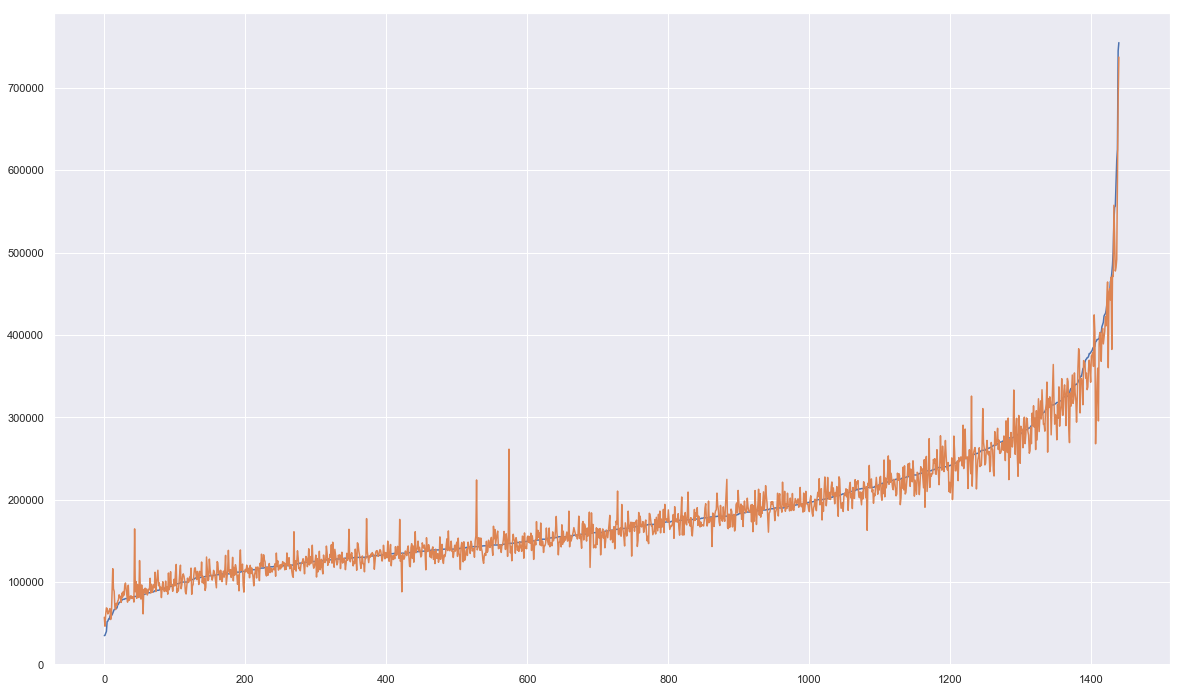

In [1121]:
sns.set()
plt.figure(figsize=(20,12))
plt.plot(x,y1)
plt.plot(x,y2)

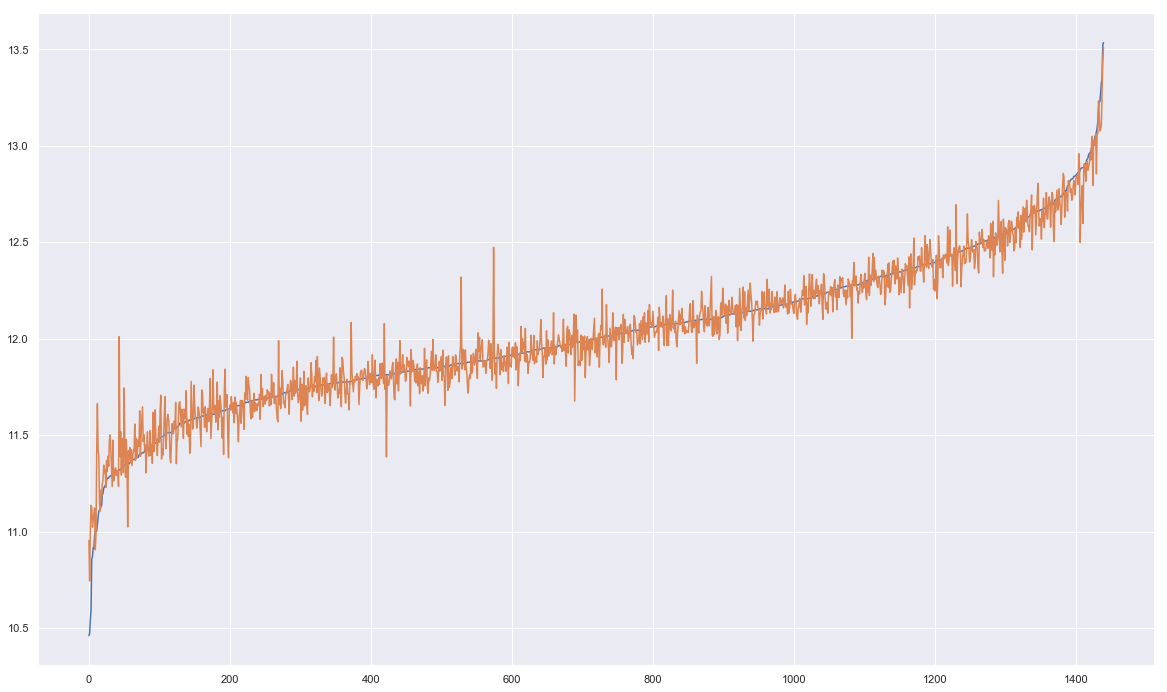

In [1122]:
sns.set()
plt.figure(figsize=(20,12))
plt.plot(x,np.log(y1))
plt.plot(x,np.log(y2))

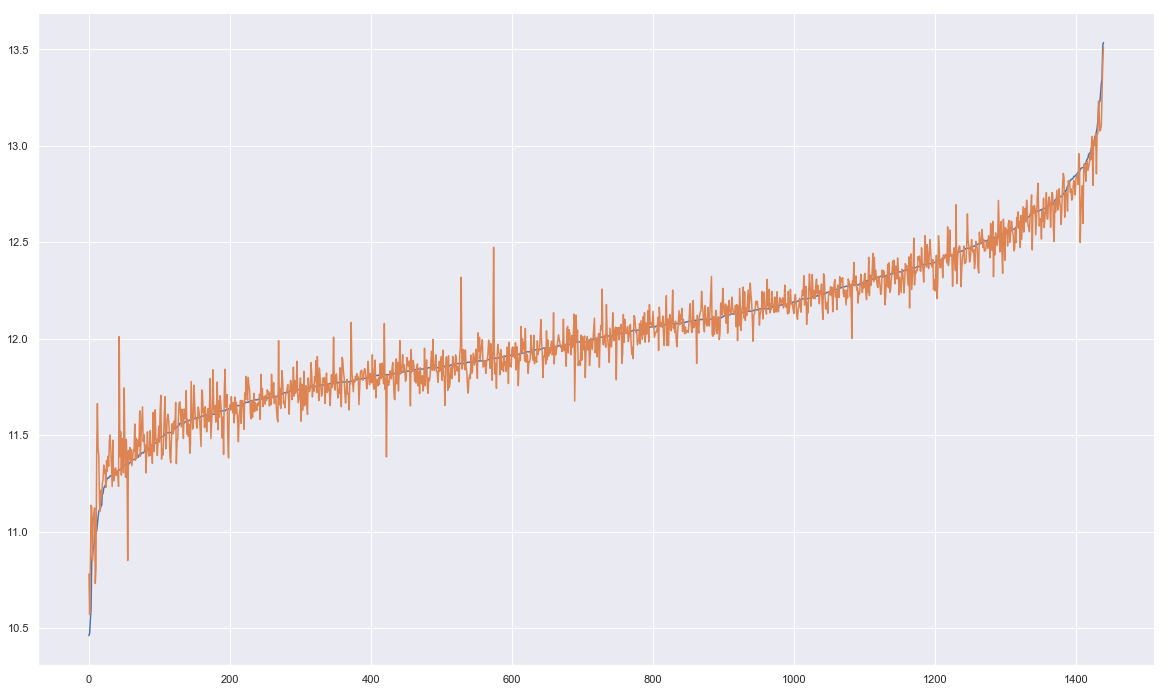

In [1124]:
y3=y2
q1 = y3['SalePrice'].quantile(0.0045) 
q2 = y3['SalePrice'].quantile(0.998)
y3['SalePrice'] = y2['SalePrice'].apply(lambda x: x if x > q1 else x*0.84)

sns.set()
plt.figure(figsize=(20,12))
plt.plot(x,np.log(y1))
plt.plot(x,np.log(y3))

In [1300]:
#对down进行操作,关键列表：q_down_list，coef_down_list，rmse_down_min_list
q_down=[0]
rmse=np.sqrt(metrics.mean_squared_error(np.log(y2),np.log(y1)))
rmse_down_min_list=[rmse]
q_down_list=[0]
coef_down_list=[]

y_temp=y2.copy()


# for i in np.arange(0,0.1,0.0005):
for i in np.arange(0,0.1,0.0005):
    q_down.append(y2['SalePrice'].quantile(i))
    rmse_temp=[]
    for j in np.arange(0.3,3,0.01):
        a = y_temp['SalePrice'].apply(lambda x: x if x >= q_down[-1] or x <= q_down[-2] else x*j)
        rmse_temp.append(np.sqrt(metrics.mean_squared_error(np.log(a),np.log(y1))))
    temp=rmse_temp-rmse_down_min_list[-1]
    if temp.min()<0:
        q_down_list.append(y2['SalePrice'].quantile(i))
        rmse_down_min_list.append(np.array(rmse_temp).min())
        coef_down_list.append(list(np.arange(0.3,3,0.01))[np.array(rmse_temp).argmin()])
        y_temp['SalePrice'] = y_temp['SalePrice'].apply(lambda x: x if x >= q_down_list[-1] or x <= q_down_list[-2] else x*coef_down_list[-1])    
        

In [1301]:
#对up进行操作,,关键列表：q_up_list，coef_up_list，rmse_up_min_list
q_up=[0]
rmse=np.sqrt(metrics.mean_squared_error(np.log(y2),np.log(y1)))
rmse_up_min_list=[rmse]
q_up_list=[0]
coef_up_list=[]

y_temp=y2.copy()


# for i in np.arange(0,0.1,0.0005):
for i in np.arange(0,0.1,0.0005):
    q_up.append(y2['SalePrice'].quantile(1-i))
    rmse_temp=[]
    for j in np.arange(0.3,3,0.01):
        a = y_temp['SalePrice'].apply(lambda x: x if x <= q_up[-1] or x >= q_up[-2] else x*j)
        rmse_temp.append(np.sqrt(metrics.mean_squared_error(np.log(a),np.log(y1))))
    temp=rmse_temp-rmse_up_min_list[-1]
    if temp.min()<0:
        q_up_list.append(y2['SalePrice'].quantile(1-i))
        rmse_up_min_list.append(np.array(rmse_temp).min())
        coef_up_list.append(list(np.arange(0.3,3,0.01))[np.array(rmse_temp).argmin()])
        y_temp['SalePrice'] = y_temp['SalePrice'].apply(lambda x: x if x <= q_up_list[-1] or x >= q_up_list[-2] else x*coef_up_list[-1])    
        

In [1302]:
q_up_list

[0, 642613.0358781919, 491500.4248942076]

In [1303]:
coef_up_list

[1.0900000000000007, 1.2400000000000009]

In [1304]:
rmse_up_min_list

[0.08854111485163099, 0.08851343909825522, 0.08835462071229781]

[0,
 55654.00404205416,
 57409.35887786327,
 60217.87958584106,
 61265.87393727395,
 61329.508413477255,
 62433.45705098263,
 63950.89426428424,
 66151.92287392884,
 66946.9131118748,
 67651.38617384946,
 68201.34330982566,
 68757.82549293223,
 70926.36276745317,
 72678.51954613456,
 74286.70795550797,
 75452.44648078855,
 75618.85318202454,
 76449.19021776158,
 77201.17979302697,
 77853.38457047392,
 78643.5023622721,
 79017.00133064178,
 79328.51923429516,
 80350.63815882582,
 81037.03434747497,
 81143.23609373756,
 81217.67209378291,
 81900.10064542771,
 82729.6923433544,
 84173.82920084879,
 84591.95086913303,
 85199.24609595019,
 87791.65565516017]

In [1317]:
#调整边缘房价
outpath='%s//reg//1220//submission//5//'%path   
submission=pd.read_csv('%s//reg//1220//blendtop//3//test_pred.csv'%path).set_index('Id')

for i in range(len(q_down_list)-1):
    submission['SalePrice']=submission['SalePrice'].apply(lambda x: x if x >= q_down_list[i+1] or x <= q_down[i] else x*coef_down_list[i])
submission.to_csv('%stest_pred.csv'%outpath)
#0.12527

In [1319]:
#调整边缘房价
outpath='%s//reg//1220//submission//6//'%path   
submission=pd.read_csv('%s//reg//1220//blendtop//3//test_pred.csv'%path).set_index('Id')

for i in range(5):
    submission['SalePrice']=submission['SalePrice'].apply(lambda x: x if x >= q_down_list[i+1] or x <= q_down[i] else x*coef_down_list[i])
submission.to_csv('%stest_pred.csv'%outpath)
#0.12100

In [ ]:
#调整边缘房价
outpath='%s//reg//1220//submission//7//'%path   
submission=pd.read_csv('%s//reg//1220//blendtop//3//test_pred.csv'%path).set_index('Id')

for i in range(len(q_up_list)-1):
    submission['SalePrice']=submission['SalePrice'].apply(lambda x: x if x <= q_up_list[-1] or x >= q_up_list[-2] else x*coef_up_list[i])
submission.to_csv('%stest_pred.csv'%outpath)
#0.12527

In [1331]:
#让超低的房价更低，让超高的房价更高(通常来说，会将小者放大，大者缩小，但房价有其特殊性：有些偏远地区的房子比预测更低，
outpath='%s//reg//1220//submission//7//'%path   
submission=pd.read_csv('%s//reg//1220//blendtop//2//test_pred.csv'%path).set_index('Id')
# q1 = submission['SalePrice'].quantile(0.0045) 
q2 = submission['SalePrice'].quantile(0.998)

submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.04)
submission.to_csv('%stest_pred.csv'%outpath)

#0.11596

In [1328]:
submission[submission>submission['SalePrice'].quantile(0.995)].SalePrice.value_counts()

552003.1     1
593549.0     1
581351.1     1
551916.2     1
615893.3     1
556821.1     1
608292.3     1
1097954.0    1
Name: SalePrice, dtype: int64

整体调整也很失败，不知道别人给出的参考方案调整在哪里。。。
等之后再过来看有没有继续提升的方法。。。
主要是从stack开始就没有提升

https://www.kaggle.com/catqaq/house-prices-top-3-0-10647-stacking

In [2]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [3]:
import mlxtend.regressor 

In [4]:
mlxtend.regressor.stacking_regression()

<module 'mlxtend.regressor' from 'C:\\Users\\sunsharp\\Anaconda3\\lib\\site-packages\\mlxtend\\regressor\\__init__.py'>